# Reporte de Progreso del Análisis de Parámetros del instrumento MATISSE

Este Jupyter Notebook presenta un análisis detallado de los parámetros de trazas del instrumento MATISSE. El objetivo principal es explorar el comportamiento operacional del instrumento, identificar patrones y detectar posibles anomalías mediante la comparación sistemática entre observaciones correctas y aquellas que presentan errores.

El análisis se ha estructurado en etapas lógicas y modulares:

1. **Extracción de datos y Análisis Inicial de Parámetros Numéricos:** 
    Carga inicial de los datos, extraccion y visualización de parámetros numericos relevantes y una primera visualización para identificar tendencias y diferencias entre las observaciones sin error y con error.

2.  **Análisis de Parámetros Categóricos:** 
    Se enfoca en la extracción, codificación a formato numérico y visualización de las variables categóricas, preparándolas para análisis más avanzados

3.  **Reducción de Dimensionalidad y Clustering:** 
    .Aplicación de técnicas avanzadas como **t-SNE** y **UMAP** para reducir la complejidad de los datos y **DBSCAN** para identificar agrupaciones naturales (clusters).

Para mantener este notebook conciso, las funciones reutilizables han sido **externalizadas en módulos Python** dentro de la carpeta `src/`. 

## 1. Extracción y Análisis Inicial de Parámetros Numéricos

Durante esta primera parte se cargan los datos desde la libreria `Eliana.datasets`, para despues identificar mediante los TPL_IDs.
Para mejorar el enfonque, se separa el dataset `df_meta` en observaciones correctas y erróneas.
Posteriormente se extraen los parámetros numéricos de las trazas para su descripción y visualización.

### Importar Librerías y Funciones
Se importan las librerías necesarias y las funciones externalizadas `src/preprocesamiento`, `src/visualizacion`, `src/codificacion` y `src/clustering`.

In [1]:
import pandas as pd
import numpy as np
from eliana.datasets import ParlogsObservations
import os
import matplotlib.pyplot as plt

# Importar funciones externalizadas de la carpeta 'src'
from src.preprocesamiento import extract_params, extract_trace_parameters, cargar_y_procesar_carpeta, extract_trace_categoricals,min_max_normalizar
from src.visualizacion import graficos_dispersion_por_columna
from src.codificacion import codificar_categoricas_por_columna, procesar_strval_in_memory 
from src.clustering import aplicar_tsne_dbscan, aplicar_umap_dbscan, cluster_y_con_tsne,procesar_archivos_especificos, plot_combined_clusters,cluster_and_plot_combined

plt.style.use('default')
plt.rcParams['font.size'] = 10

### Cargar datos del dataset Eliana
* Instrumento: MATISSE
* Rango de tiempo: 6 meses

In [2]:
INSTRUMENT='MATISSE'
RANGE='6m'

In [3]:
logs = ParlogsObservations(period=RANGE, source="Instrument", system=INSTRUMENT)

### Información General de los DataFrames

In [4]:
df_meta = logs.meta
df_traces = logs.traces()
TPL_IDs = logs.meta['TPL_ID'].value_counts()
print("Conteo de TPL_IDs:\n", TPL_IDs)

Conteo de TPL_IDs:
 TPL_ID
MATISSE_hyb_obs                      1612
MATISSE_img_acq                      1467
MATISSE_gen_tec_opd                  1059
MATISSE_gen_cal_bias                  724
MATISSE_gen_cal_imbasic               399
MATISSE_gen_cal_transfunc             241
MATISSE_gen_tec_standby               199
MATISSE_gen_tec_ali                   185
MATISSE_gen_tec_check_fringes         183
MATISSE_img_acq_ft                    174
MATISSE_gen_tec_simple_rec            130
MATISSE_gen_cal_kappa                  56
MATISSE_gen_cal_shift                  50
CALOB_gen_tec_log                      37
errseverity                            33
MATISSE_gen_tec_setup_coude_train      27
MATISSE_gen_cal_det_aq                 22
MATISSE_gen_cal_det_h2                 21
MATISSE_gen_tec_piezos                 13
MATISSE_gen_tec_setup_lab               7
MATISSE_gen_cal_imext_aq                5
MATISSE_gen_cal_imrem_aq                3
MATISSE_gen_cal_imrem                   2
MATISSE

In [5]:
TPL_IDs_Error=df_meta[df_meta['ERROR'] == True]
print("Conteo de TPL_IDs con ERROR:\n", TPL_IDs_Error['TPL_ID'].value_counts())

Conteo de TPL_IDs con ERROR:
 TPL_ID
MATISSE_gen_tec_ali              67
MATISSE_hyb_obs                  43
MATISSE_img_acq                  39
errseverity                      27
MATISSE_img_acq_ft               23
MATISSE_gen_tec_opd              20
MATISSE_gen_cal_det_aq           15
MATISSE_gen_tec_check_fringes    10
MATISSE_gen_cal_bias              9
MATISSE_gen_cal_imbasic           6
MATISSE_gen_cal_det_h2            3
MATISSE_gen_cal_shift             3
MATISSE_gen_cal_kappa             2
MATISSE_gen_tec_piezos            2
MATISSE_gen_cal_transfunc         1
Name: count, dtype: int64


In [6]:
TPL = set(TPL_IDs.index) & set(TPL_IDs_Error['TPL_ID'])
print("TPL_IDs con errores comunes:\n", TPL)

TPL_IDs con errores comunes:
 {'MATISSE_img_acq_ft', 'MATISSE_gen_cal_transfunc', 'MATISSE_gen_tec_ali', 'MATISSE_gen_tec_check_fringes', 'MATISSE_img_acq', 'MATISSE_gen_tec_piezos', 'MATISSE_gen_cal_shift', 'MATISSE_gen_cal_det_aq', 'MATISSE_gen_cal_kappa', 'MATISSE_gen_cal_det_h2', 'MATISSE_gen_cal_imbasic', 'MATISSE_gen_cal_bias', 'errseverity', 'MATISSE_hyb_obs', 'MATISSE_gen_tec_opd'}


In [7]:
print("Conteo de errores en metadatos:\n", df_meta['ERROR'].value_counts())

Conteo de errores en metadatos:
 ERROR
False    6383
True      270
Name: count, dtype: int64


### Separación de los datos:
Se crean dos DataFrames de `df_meta`: uno para las observaciones con errores (`df_meta_Error`) y otro para las que no tienen errores (`df_meta_2`).

In [8]:
df_meta_Error = df_meta[df_meta['ERROR'] == True]

In [9]:
df_meta_2 = df_meta[~df_meta['START'].isin(df_meta_Error['START'])]

### Extracción y Almacenamiento de Parámetros Numéricos
Se extraen los parámetros numéricos de las trazas para los TPL_IDs identificados, tanto para las observaciones sin error como para las que tienen error. 

In [10]:
output_dir_ok_num = "params_por_tpl"
output_dir_err_num = "params_por_tpl_Error"

os.makedirs(output_dir_ok_num, exist_ok=True)
os.makedirs(output_dir_err_num, exist_ok=True)

tpl_params_dict_ok = {}
tpl_params_dict_err = {}

threshold_nan = 0.5

for tpl_id in TPL:
    params_df_ok = extract_trace_parameters(df_meta_2, df_traces, extract_params, tpl_id=tpl_id)
    
    params_df_ok = params_df_ok.loc[:, params_df_ok.isna().mean() < threshold_nan]
    params_df_ok = params_df_ok.loc[params_df_ok.isna().mean(axis=1) < threshold_nan, :]

    if not params_df_ok.empty:
        tpl_params_dict_ok[tpl_id] = params_df_ok
        safe_tpl_id = str(tpl_id).replace("/", "_").replace(" ", "_")
        filename_ok = os.path.join(output_dir_ok_num, f"params_{safe_tpl_id}.csv")
        params_df_ok.to_csv(filename_ok)
        
    params_df_err = extract_trace_parameters(df_meta_Error, df_traces, extract_params, tpl_id=tpl_id)
    
    params_df_err = params_df_err.loc[:, params_df_err.isna().mean() < threshold_nan]
    params_df_err = params_df_err.loc[params_df_err.isna().mean(axis=1) < threshold_nan, :]

    if not params_df_err.empty:
        tpl_params_dict_err[tpl_id] = params_df_err
        safe_tpl_id = str(tpl_id).replace("/", "_").replace(" ", "_")
        filename_err = os.path.join(output_dir_err_num, f"params_{safe_tpl_id}.csv")
        params_df_err.to_csv(filename_err)
    

### Descripción de Parámetros Numéricos


In [12]:
print("\n Parametros Numericos")

# Sin Error
non_empty_ok = [tpl_id for tpl_id, df in tpl_params_dict_ok.items() if not df.empty]
if non_empty_ok:
    print(f"Sin Error ({len(non_empty_ok)}): {', '.join(non_empty_ok)}")
else:
    print(" Sin Error: Ninguno")

# Con Error  
non_empty_err = [tpl_id for tpl_id, df in tpl_params_dict_err.items() if not df.empty]
if non_empty_err:
    print(f"Con Error ({len(non_empty_err)}): {', '.join(non_empty_err)}")
else:
    print(" Con Error: Ninguno")

# Estadísticas rápidas solo si hay datos
for label, data_dict in [("Sin Error", tpl_params_dict_ok), ("Con Error", tpl_params_dict_err)]:
    total_rows = sum(len(df) for df in data_dict.values() if not df.empty)
    if total_rows > 0:
        print(f"{label}: {total_rows} registros totales")


 Parametros Numericos
Sin Error (15): MATISSE_img_acq_ft, MATISSE_gen_cal_transfunc, MATISSE_gen_tec_ali, MATISSE_gen_tec_check_fringes, MATISSE_img_acq, MATISSE_gen_tec_piezos, MATISSE_gen_cal_shift, MATISSE_gen_cal_det_aq, MATISSE_gen_cal_kappa, MATISSE_gen_cal_det_h2, MATISSE_gen_cal_imbasic, MATISSE_gen_cal_bias, errseverity, MATISSE_hyb_obs, MATISSE_gen_tec_opd
Con Error (15): MATISSE_img_acq_ft, MATISSE_gen_cal_transfunc, MATISSE_gen_tec_ali, MATISSE_gen_tec_check_fringes, MATISSE_img_acq, MATISSE_gen_tec_piezos, MATISSE_gen_cal_shift, MATISSE_gen_cal_det_aq, MATISSE_gen_cal_kappa, MATISSE_gen_cal_det_h2, MATISSE_gen_cal_imbasic, MATISSE_gen_cal_bias, errseverity, MATISSE_hyb_obs, MATISSE_gen_tec_opd
Sin Error: 5956 registros totales
Con Error: 266 registros totales


### Gráficos de Dispersión de Parámetros Numéricos
Se generan gráficos de dispersión para comparar los parámetros numéricos entre las observaciones con y sin error, omitiendo los parámetros que se mantienen constantes en ambos grupos. Se procesan solo los archivos específicos.

Generando gráficos para los TPL_IDs: MATISSE_hyb_obs, MATISSE_img_acq, MATISSE_img_acq_ft

Comparando MATISSE_hyb_obs.csv
Creando gráficos para 17 parámetros NO constantes...
Parámetros constantes (omitidos): ['TEL.CHOP.PVRATIO', 'DET2.INTERFX.VAL', 'DET1.APOTYPE.VAL', 'DET1.APOY.VAL', 'SEQ.OPDM.N.WLMAX', 'DET2.WLMINCUT.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'SEQ.OPDM.L.WLMAX', 'DET2.NCOHERENT.VAL', 'DET1.APOX.VAL', 'DET2.INTERFY.VAL', 'DET2.SNRLIMIT.VAL', 'DET1.SNRLIMIT.VAL', 'TEL.CHOP.POSANG', 'DET2.NINCOHERENT.VAL', 'DET1.INTERFX.VAL', 'DET2.APOY.VAL']
Observaciones sin error: 1569
Observaciones con error: 43


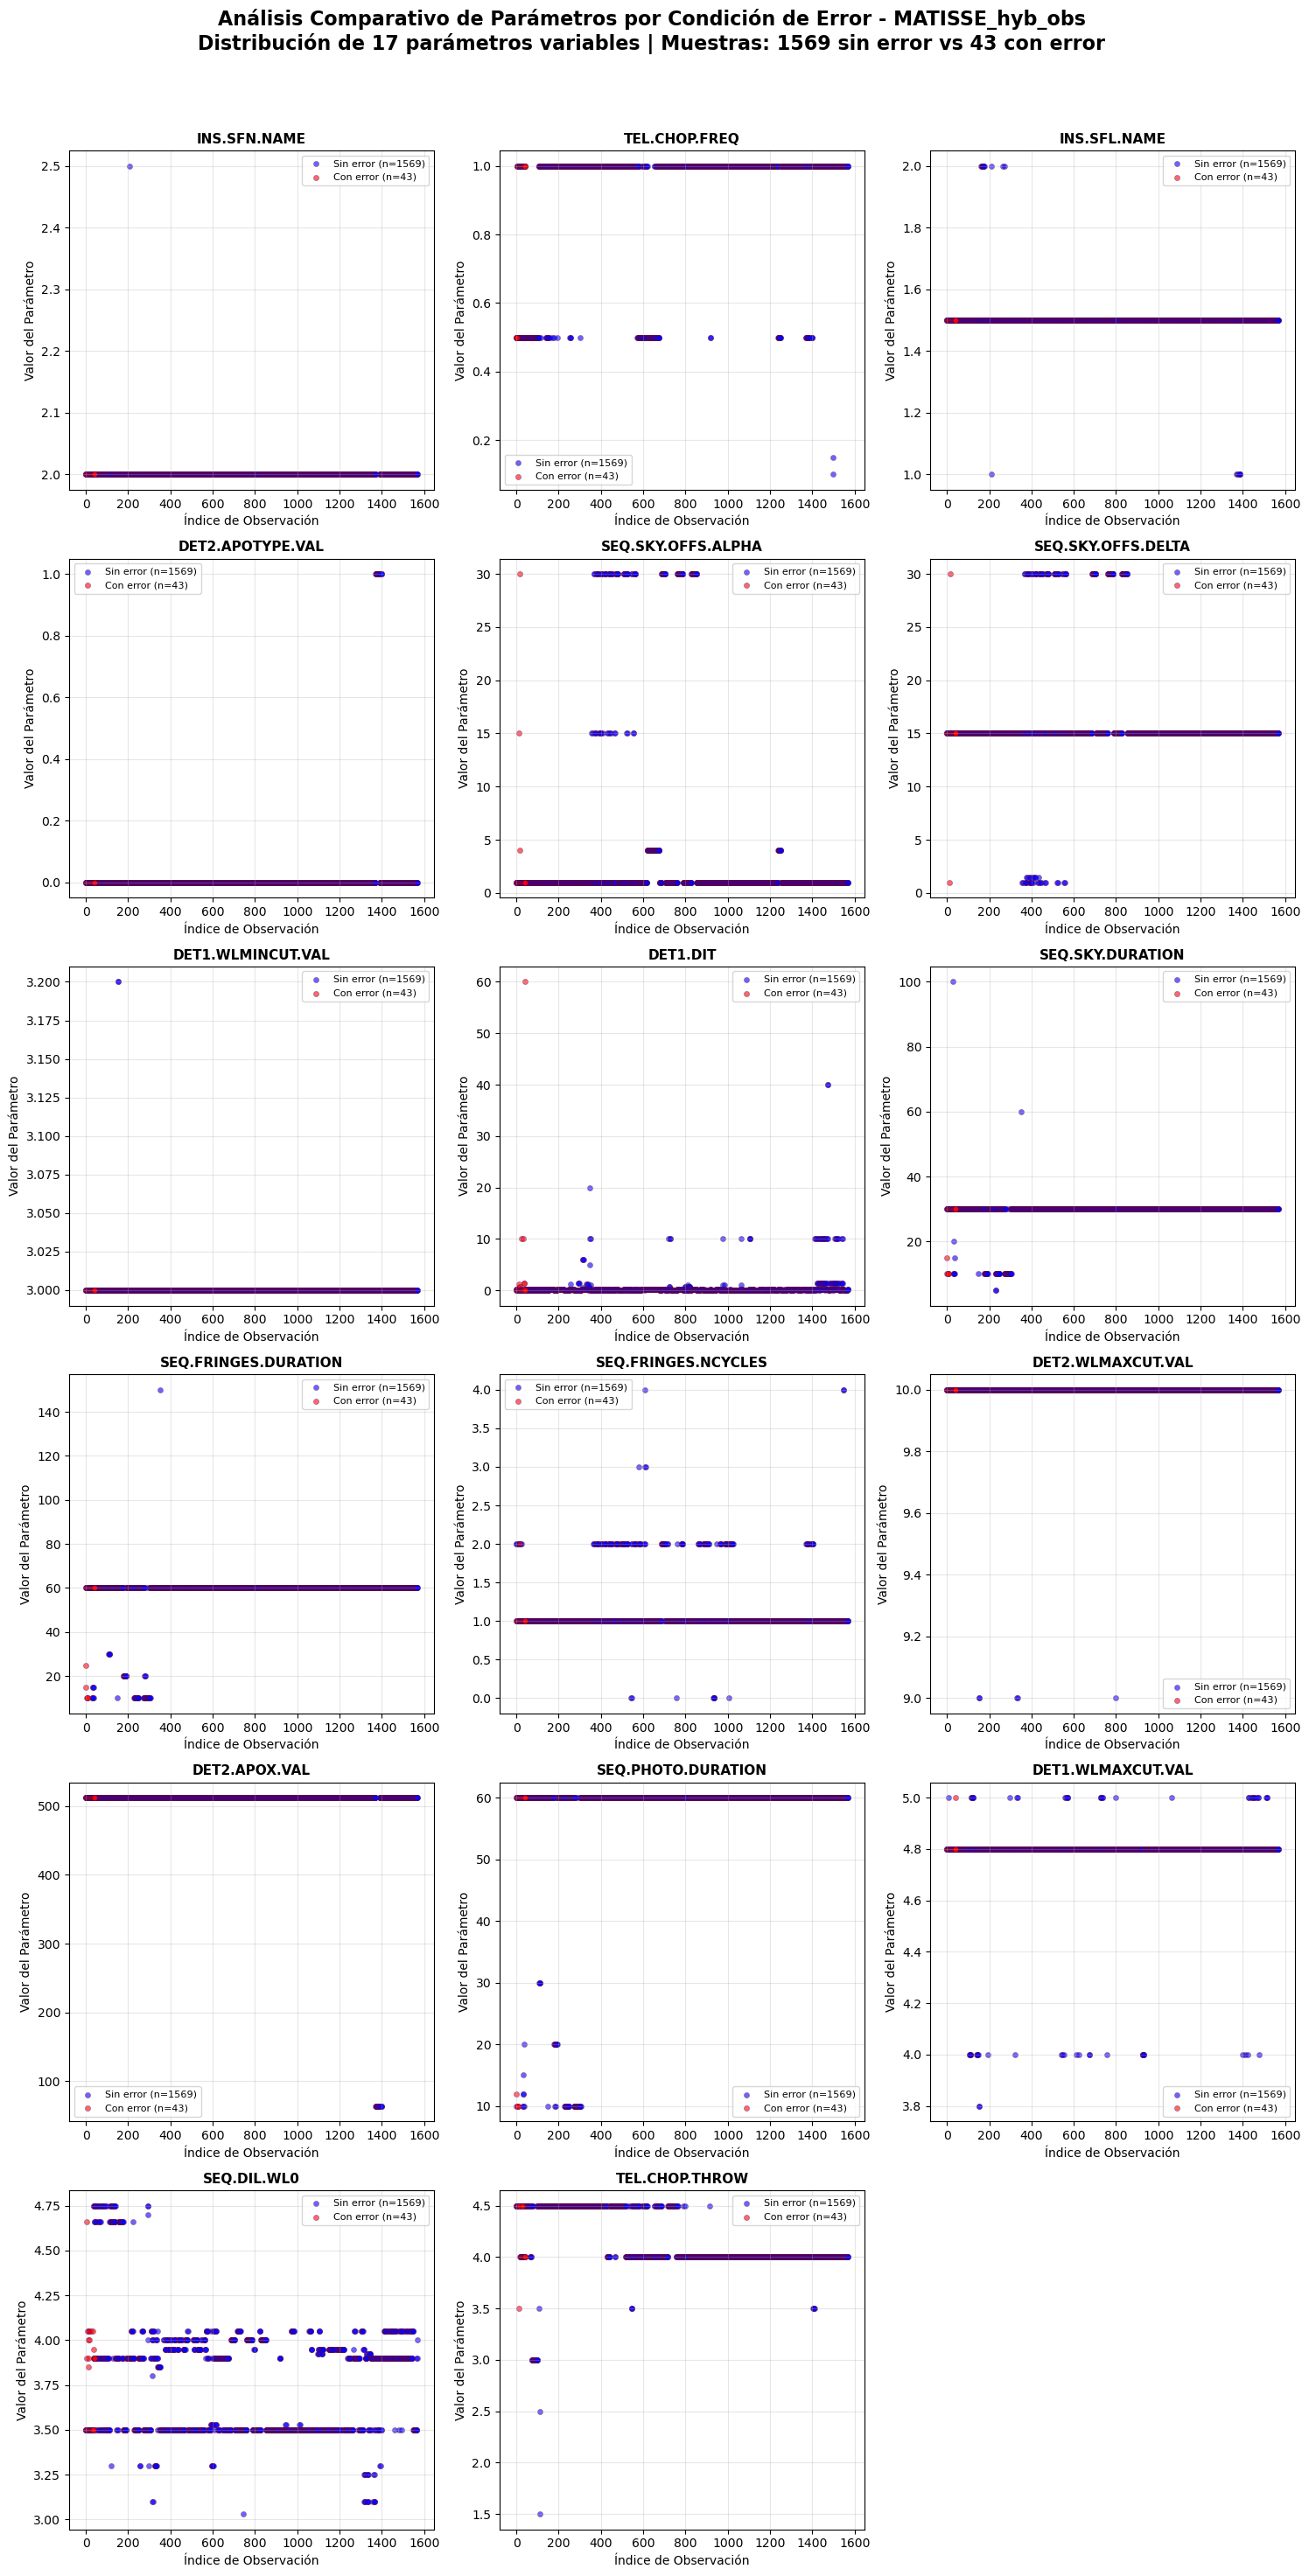


Comparando MATISSE_img_acq.csv
Creando gráficos para 27 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.PUP.SKY.DURATION', 'TEL.CHOP.PVRATIO', 'SEQ.ACQ.SKY.DURATION', 'DET2.INTERFX.VAL', 'SEQ.SKY.OFFS.ALPHA', 'DEL.REF.OPL', 'DET1.APOTYPE.VAL', 'DET1.APOY.VAL', 'SEQ.SKY.OFFS.DELTA', 'SEQ.OPDM.N.WLMAX', 'DET2.WLMINCUT.VAL', 'DET1.INTERFY.VAL', 'COU.AG.EPOCH', 'DET1.NCOHERENT.VAL', 'TEL.GS1.MAG', 'TEL.TARG.EQUINOX', 'DET1.NINCOHERENT.VAL', 'TEL.GS1.ALPHA', 'SEQ.OPDM.L.WLMAX', 'COU.AG.EQUINOX', 'DET1.APOX.VAL', 'DET2.NCOHERENT.VAL', 'DET2.INTERFY.VAL', 'DET2.WLMAXCUT.VAL', 'SEQ.ACQ.TARG.DURATION', 'DET2.SNRLIMIT.VAL', 'SEQ.PUP.TARG.DURATION', 'SEQ.FS.INS.SFN.NAME', 'DET1.SNRLIMIT.VAL', 'DET2.NINCOHERENT.VAL', 'DET1.INTERFX.VAL', 'SEQ.FS.SKY.DURATION', 'SEQ.DIL.WL0', 'DET2.APOY.VAL', 'TEL.GS1.DELTA']
Observaciones sin error: 1425
Observaciones con error: 38


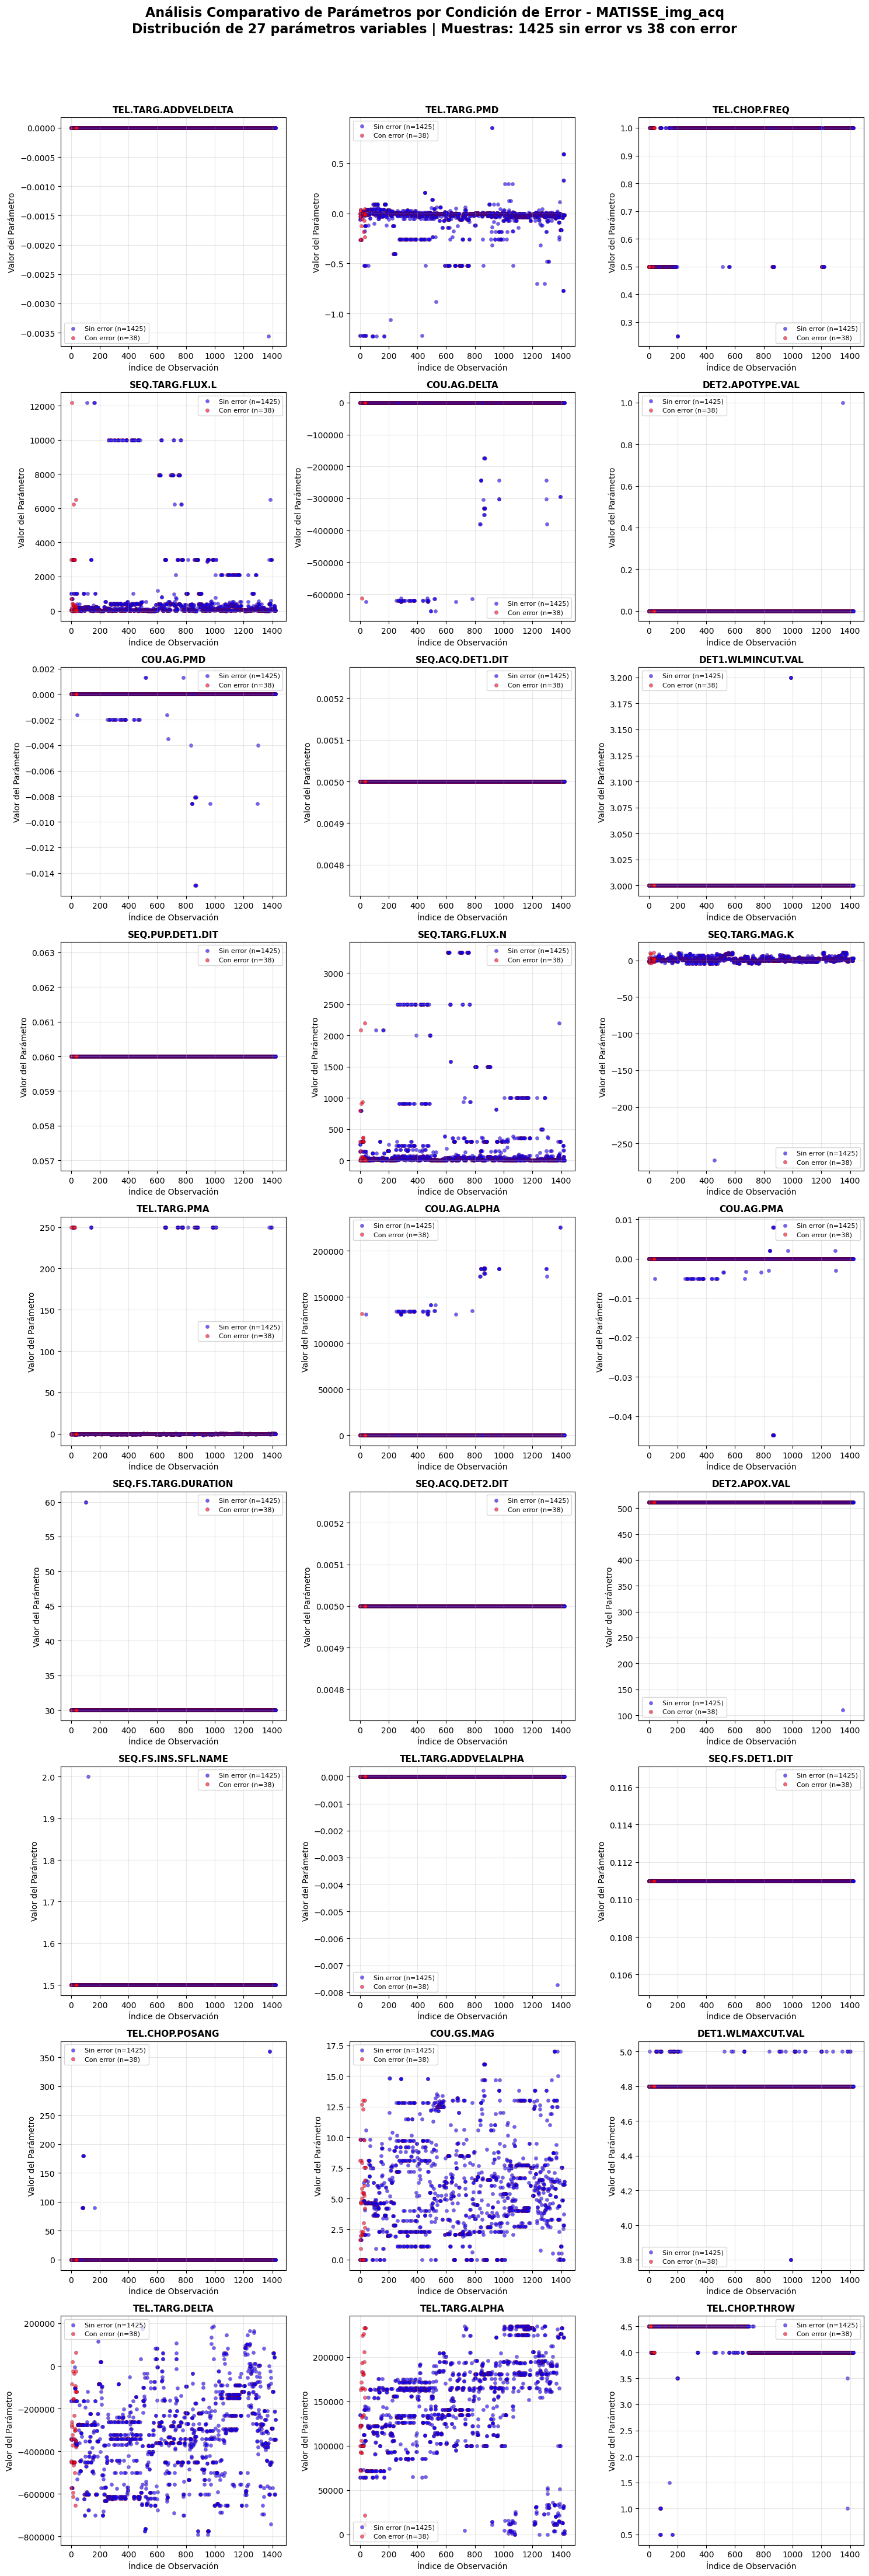


Comparando MATISSE_img_acq_ft.csv
Creando gráficos para 15 parámetros NO constantes...
Parámetros constantes (omitidos): ['TEL.TARG.ADDVELDELTA', 'SEQ.PUP.SKY.DURATION', 'SEQ.SKY.Y', 'COU.AG.DELTA', 'DET2.APOTYPE.VAL', 'COU.AG.PMD', 'SEQ.ACQ.SKY.DURATION', 'SEQ.SKY.OFFS.ALPHA', 'DET2.INTERFX.VAL', 'DEL.REF.OPL', 'DET1.APOTYPE.VAL', 'DET1.APOY.VAL', 'SEQ.SKY.OFFS.DELTA', 'SEQ.OPDM.N.WLMAX', 'DET2.WLMINCUT.VAL', 'DET1.INTERFY.VAL', 'DET1.WLMINCUT.VAL', 'COU.AG.EPOCH', 'DET1.NCOHERENT.VAL', 'TEL.GS1.MAG', 'TEL.TARG.EQUINOX', 'DET1.NINCOHERENT.VAL', 'TEL.GS1.ALPHA', 'COU.AG.ALPHA', 'COU.AG.PMA', 'SEQ.OPDM.L.WLMAX', 'COU.AG.EQUINOX', 'DET1.APOX.VAL', 'DET2.NCOHERENT.VAL', 'DET2.INTERFY.VAL', 'DET2.NDIT.SKY', 'DET2.SNRLIMIT.VAL', 'SEQ.ACQ.TARG.DURATION', 'SEQ.SKY.X', 'DET2.APOX.VAL', 'SEQ.PUP.TARG.DURATION', 'DET1.SNRLIMIT.VAL', 'INS.STSOFFANG', 'TEL.TARG.ADDVELALPHA', 'DET2.NINCOHERENT.VAL', 'DET1.INTERFX.VAL', 'SEQ.DIL.WL0', 'DET2.APOY.VAL', 'TEL.GS1.DELTA', 'DEL.REF.NAME']
Observaciones 

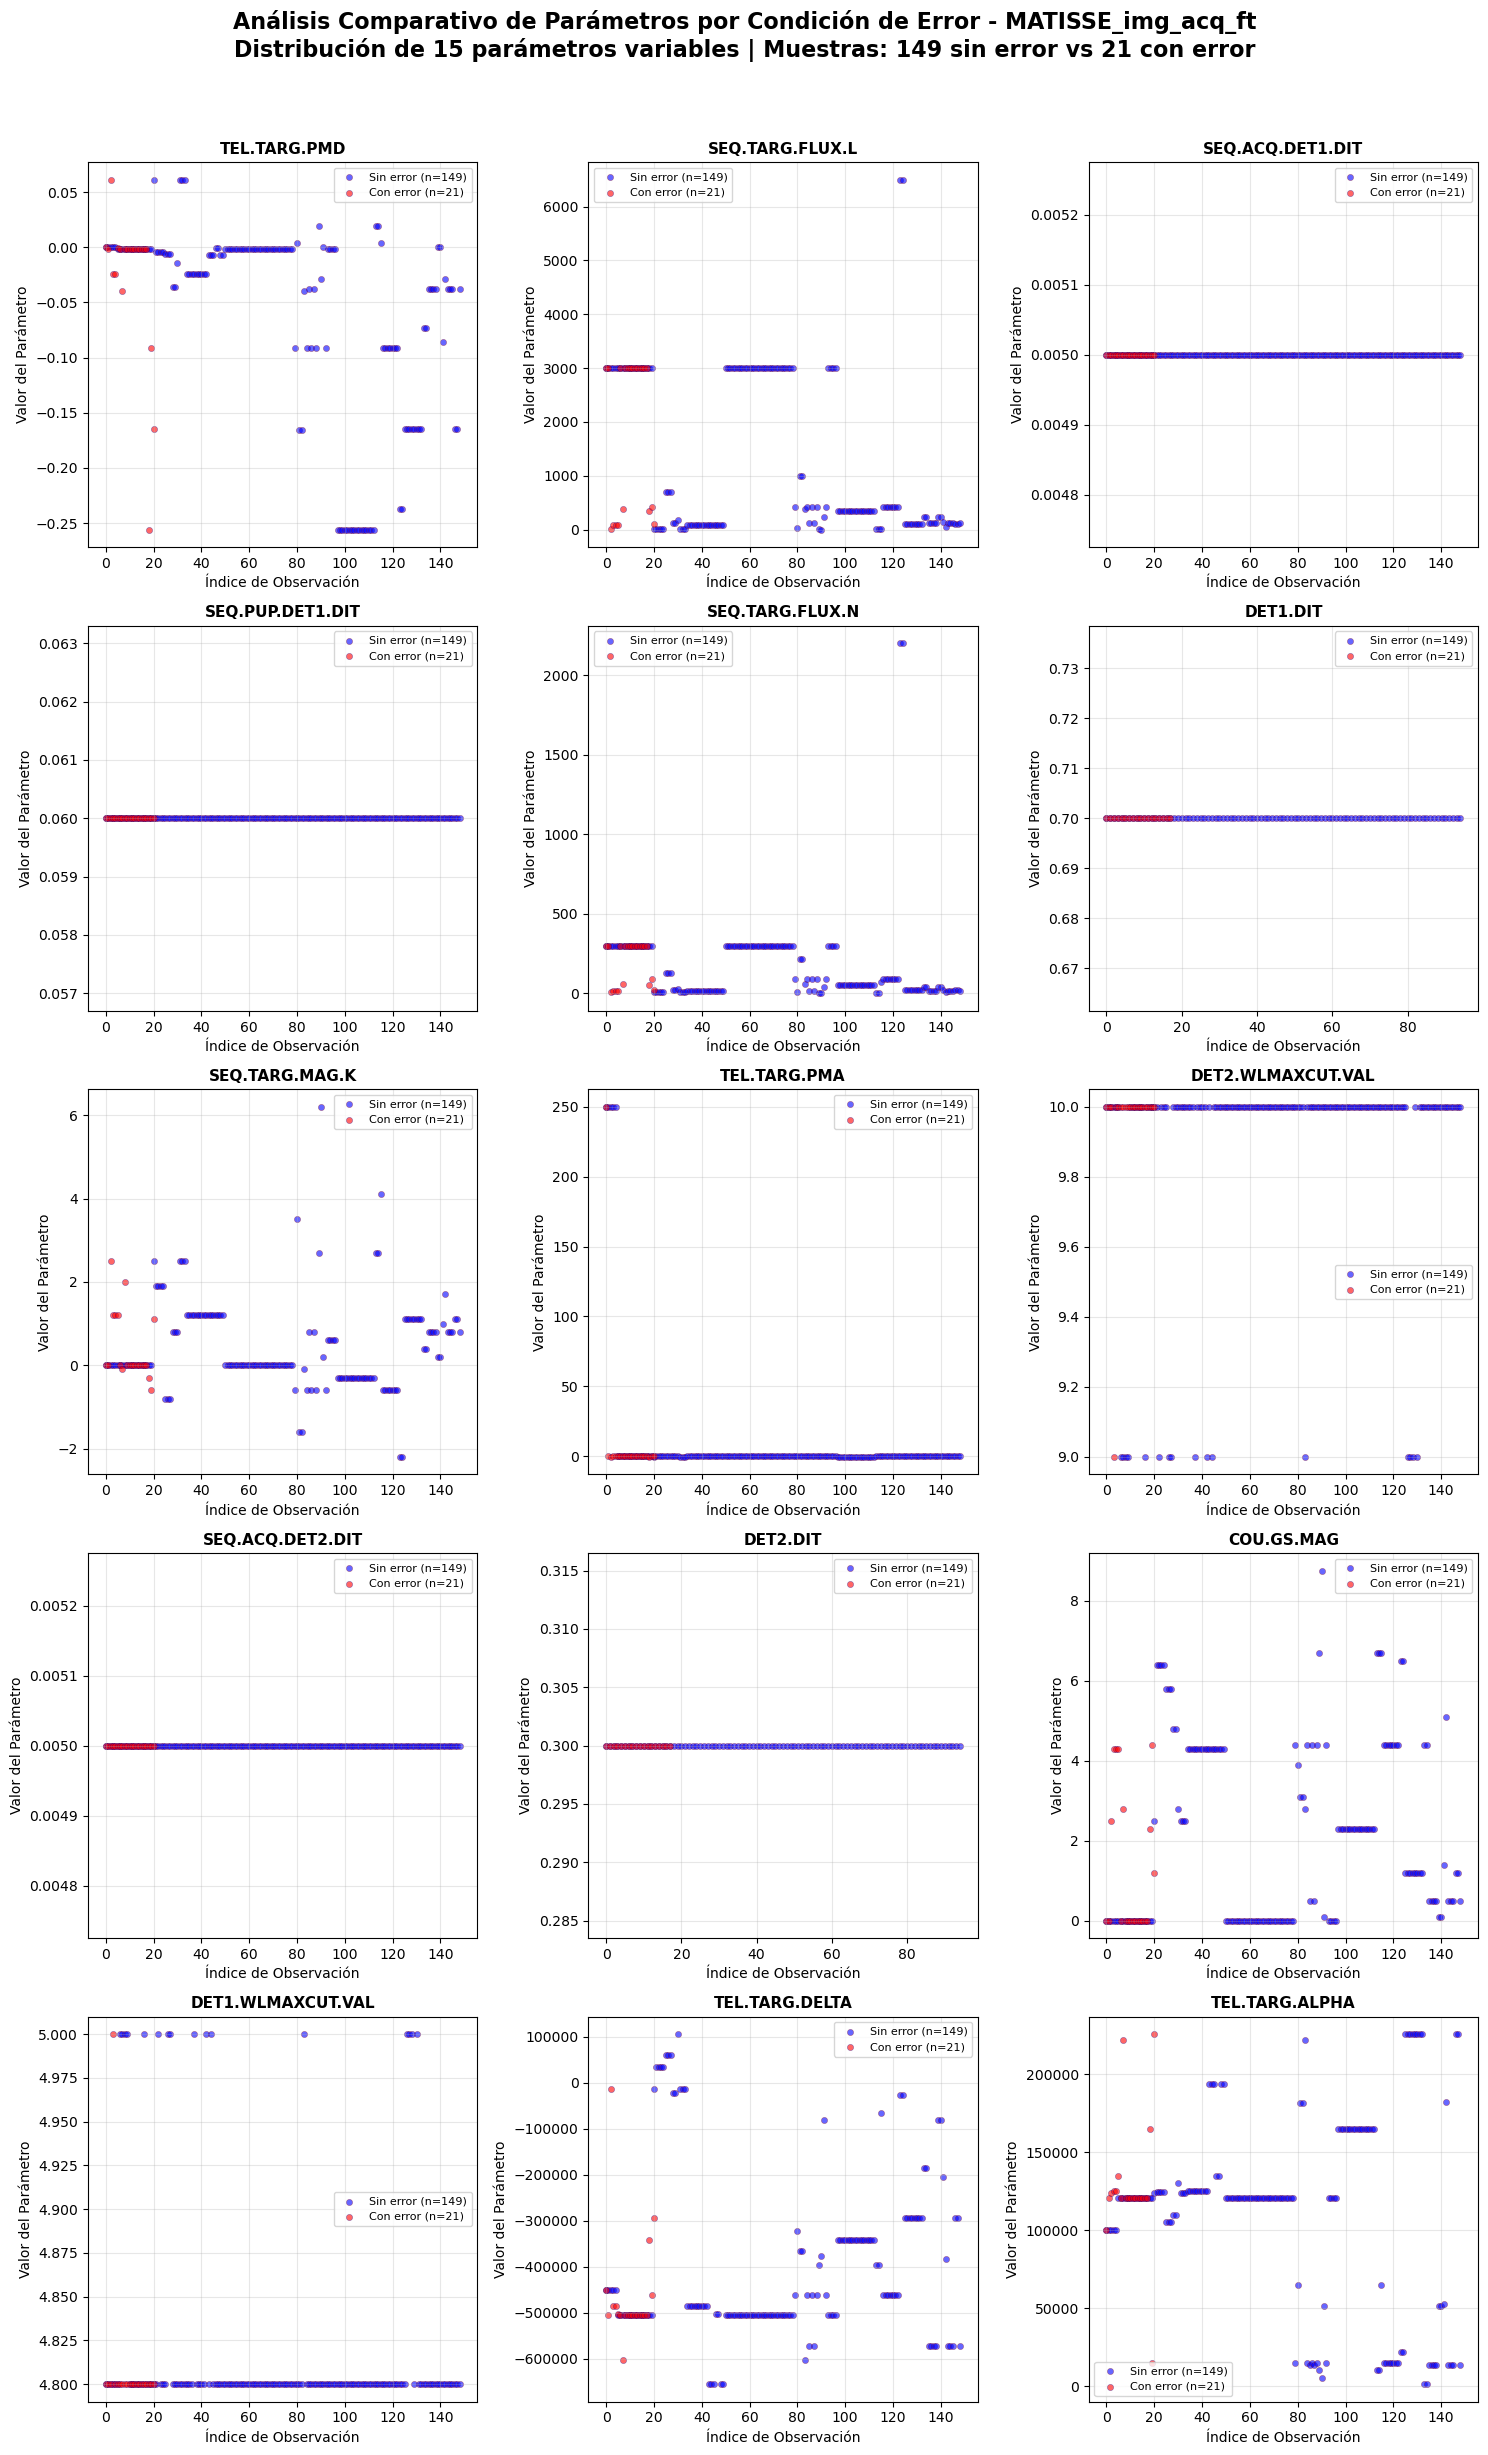

In [ ]:
archivos_especificos_tpls = [
    'MATISSE_hyb_obs',
    'MATISSE_img_acq',
    'MATISSE_img_acq_ft'
]

for tpl_id_str in archivos_especificos_tpls:
    df_ok = tpl_params_dict_ok.get(tpl_id_str)
    df_err = tpl_params_dict_err.get(tpl_id_str)

    if df_ok is not None and not df_ok.empty and df_err is not None and not df_err.empty:
        print(f"\nComparando {tpl_id_str}.csv")
        columns = list(set(df_ok.columns) & set(df_err.columns))
        if columns:
            graficos_dispersion_por_columna(df_ok[columns], df_err[columns], nombre_archivo=tpl_id_str)
        else:
            print(f"No hay columnas comunes para comparar en {tpl_id_str}.csv.")
    else:
        print(f"No se encontraron DataFrames válidos (sin error o con error) para {tpl_id_str}. Se omite.")

Analisis Graficos:

- **`img_acq_ft`**: Alta diferenciación entre error y no error. Varios parámetros muestran claras diferencias. **Más recomendable para modelos.**
- **`img_acq`**: Dispersión más alta, pero aún se observan patrones útiles. 
- **`hyb_obs`**: Parámetros muy concentrados, poca variabilidad.

## 2. Extracción y Codificación de Parámetros Categóricos

Se extraen los parametros con valor categoricos, para posteriormente codificarlos numéricamente y visualizar los resultados.

### Extracción de Parámetros Categóricos (strval) en Memoria
Se extraen los parámetros categóricos de las trazas y se almacenan directamente en diccionarios de DataFrames en memoria. 

In [14]:
tpl_strval_dict_ok = {}
tpl_strval_dict_err = {}

for tpl_id in TPL:
    strval_df_ok = extract_trace_categoricals(df_meta_2, df_traces, extract_params, tpl_id=tpl_id)

    if not strval_df_ok.empty:
        tpl_strval_dict_ok[tpl_id] = strval_df_ok
   
    strval_df_err = extract_trace_categoricals(
        df_meta_Error,
        df_traces,
        extract_params,
        tpl_id=tpl_id
    )

    if not strval_df_err.empty:
        tpl_strval_dict_err[tpl_id] = strval_df_err


### Codificación de Parámetros Categóricos en Memoria
Se aplica una codificación numérica a los parámetros categóricos directamente desde los DataFrames en memoria.

In [15]:
codified_strval_ok_dfs, dict_codificacion_ok = procesar_strval_in_memory(
    tpl_strval_dict_ok
)

codified_strval_err_dfs, dict_codificacion_err = procesar_strval_in_memory(
    tpl_strval_dict_err
)

print("\nCodificación de categóricas completada.")


Codificación de categóricas completada.


### Gráficos de Dispersión de Parámetros Categóricos Codificados
Se generan gráficos de dispersión para los parámetros categóricos ya codificados, comparando las observaciones con y sin error. Se aplica el mismo filtro de parámetros constantes que en la sección de numéricos, utilizando los DataFrames en memoria.

Creando gráficos para 22 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.RMNREC.ST', 'INS.POL.NAME', 'TEL.CHOP.FREQ', 'DET2.APOTYPE.VAL', 'SEQ.SKY.OFFS.ALPHA', 'TEL.CHOP.PVRATIO', 'DET2.INTERFX.VAL', 'DET1.APOTYPE.VAL', 'DET1.APOY.VAL', 'SEQ.SKY.OFFS.DELTA', 'SEQ.OPDM.N.WLMAX', 'DET2.WLMINCUT.VAL', 'DET1.INTERFY.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'INS.FIN.NAME', 'SEQ.SKY.DURATION', 'SEQ.FRINGES.DURATION', 'SEQ.OPDM.L.WLMAX', 'SEQ.FRINGES.NCYCLES', 'DET2.NCOHERENT.VAL', 'DET1.APOX.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.INTERFY.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.APOX.VAL', 'DET2.READ.CURNAME', 'INS.PON.NAME', 'DET1.SNRLIMIT.VAL', 'SEQ.PHOTO.DURATION', 'TEL.CHOP.POSANG', 'DET2.NINCOHERENT.VAL', 'DET1.INTERFX.VAL', 'DET1.WLMAXCUT.VAL', 'SEQ.DIL.WL0', 'TEL.CHOP.THROW']
Observaciones sin error: 1569
Observaciones con error: 43


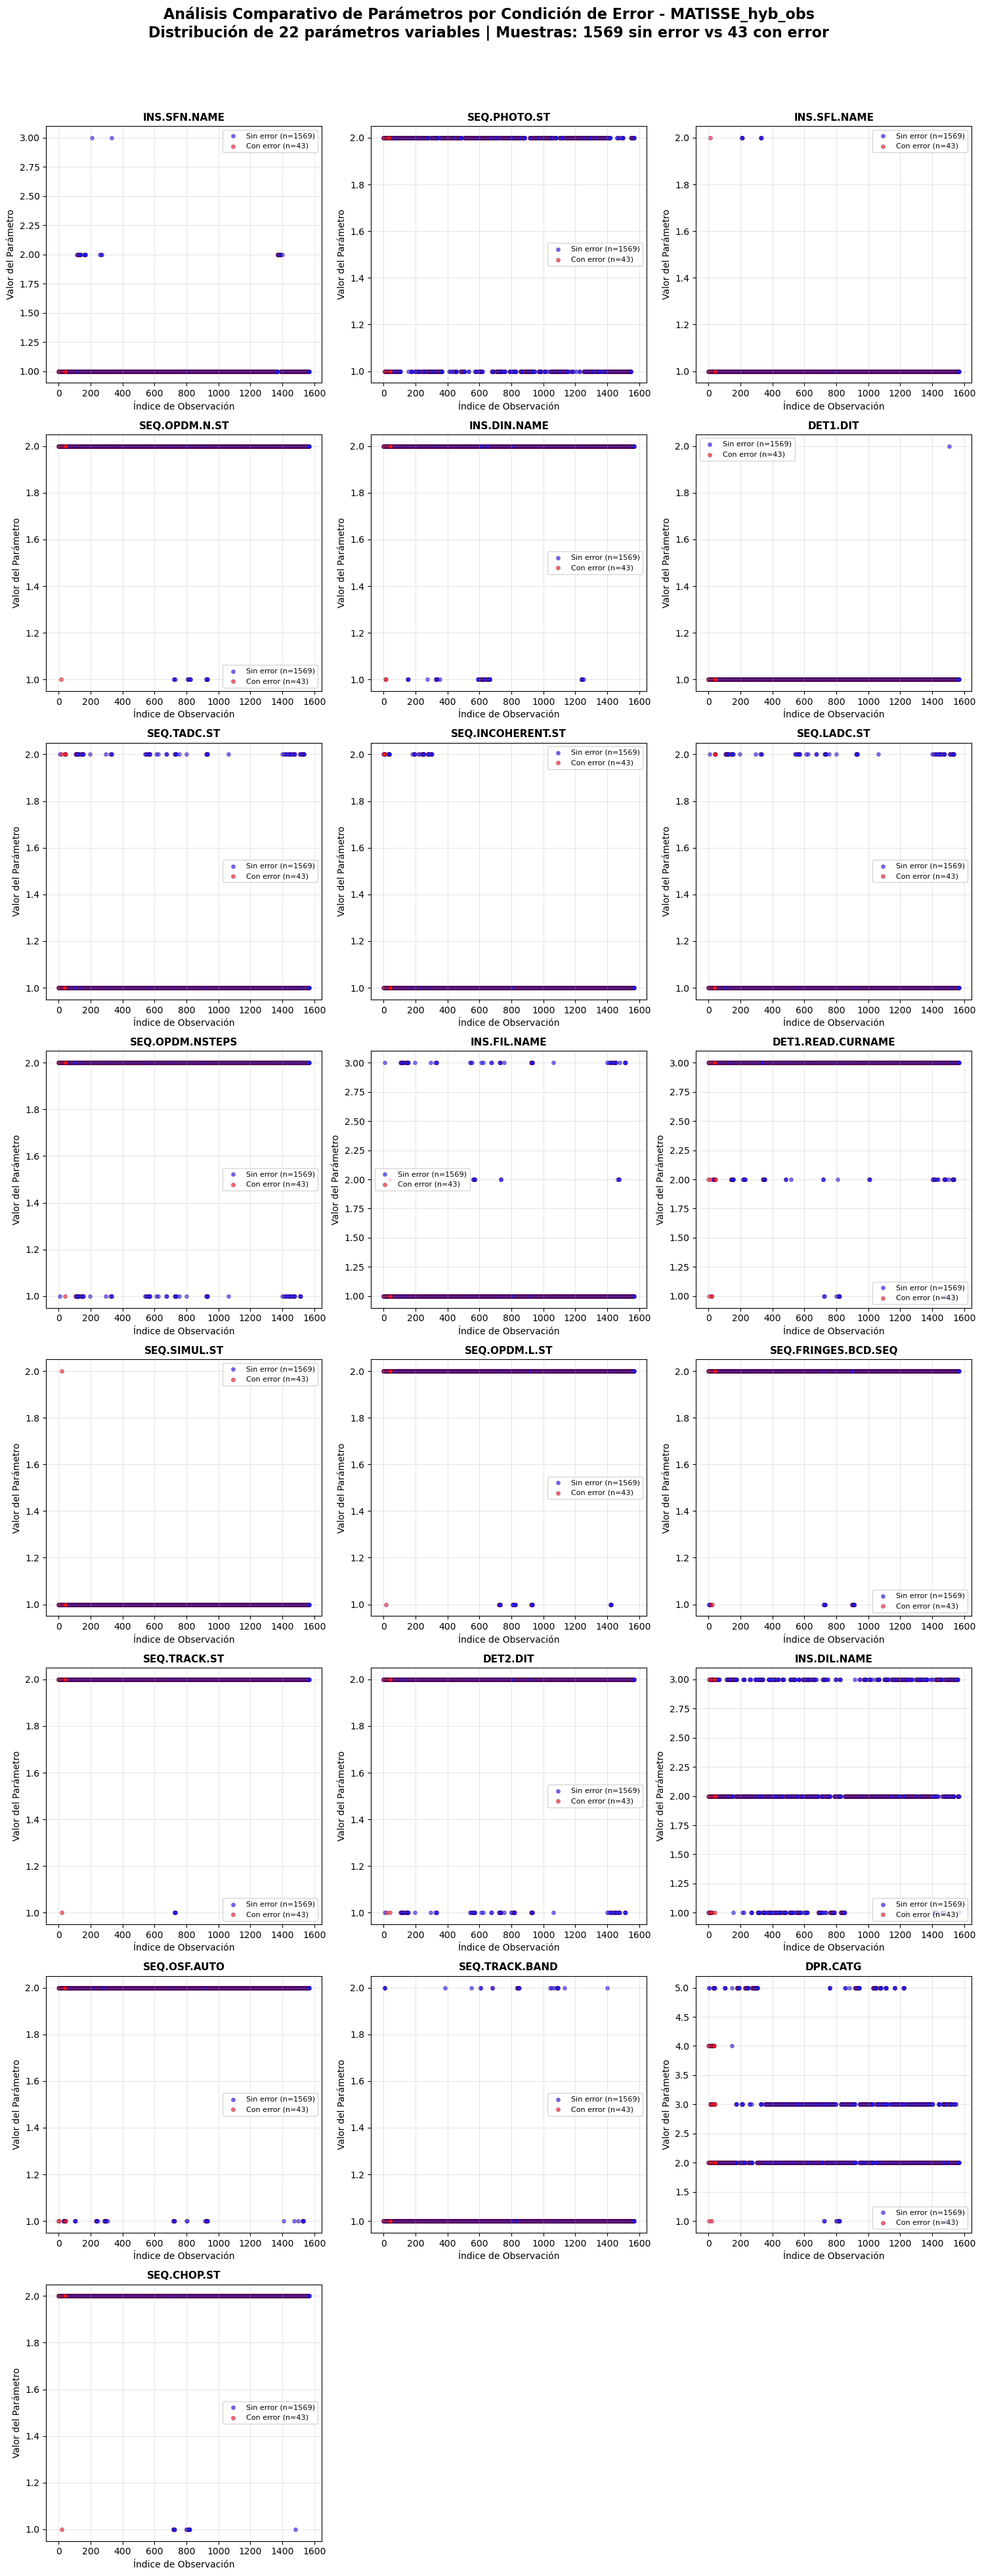

Creando gráficos para 20 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.ACQ.SKY.DURATION', 'SEQ.SKY.OFFS.DELTA', 'DET2.WLMINCUT.VAL', 'SEQ.PUP.DET1.DIT', 'TEL.TARG.PMA', 'DET1.NINCOHERENT.VAL', 'SEQ.ACQ.DET2.DIT', 'SEQ.OPDM.L.ST', 'SEQ.FS.INS.SFL.NAME', 'SEQ.FS.INS.FIL.NAME', 'SEQ.FS.DET1.DIT', 'DEL.REF.MODE', 'SEQ.FS.INS.FIN.NAME', 'COU.AG.DELTA', 'SEQ.SKY.OFFS.ALPHA', 'DET1.APOY.VAL', 'SEQ.OPDM.N.WLMAX', 'SEQ.TARG.FLUX.N', 'TEL.GS1.MAG', 'TEL.GS1.ALPHA', 'COU.AG.PMA', 'COU.AG.EQUINOX', 'SEQ.ACQ.TARG.DURATION', 'TEL.TARG.ADDVELALPHA', 'TEL.CHOP.POSANG', 'COU.GS.MAG', 'DET1.WLMAXCUT.VAL', 'SEQ.ACQ.INS.FIN.NAME', 'DET2.APOY.VAL', 'TEL.CHOP.THROW', 'SEQ.PUP.SKY.DURATION', 'COU.AG.PMD', 'DET2.APOTYPE.VAL', 'TEL.CHOP.PVRATIO', 'DET2.INTERFX.VAL', 'DET1.APOTYPE.VAL', 'SEQ.OPDM.N.ST', 'SEQ.FS.INS.DIN.NAME', 'DET1.WLMINCUT.VAL', 'SEQ.TARG.MAG.K', 'COU.AG.ALPHA', 'SEQ.FS.TARG.DURATION', 'DET2.NCOHERENT.VAL', 'DET1.APOX.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.INTERFY.VAL', 'DET2.S

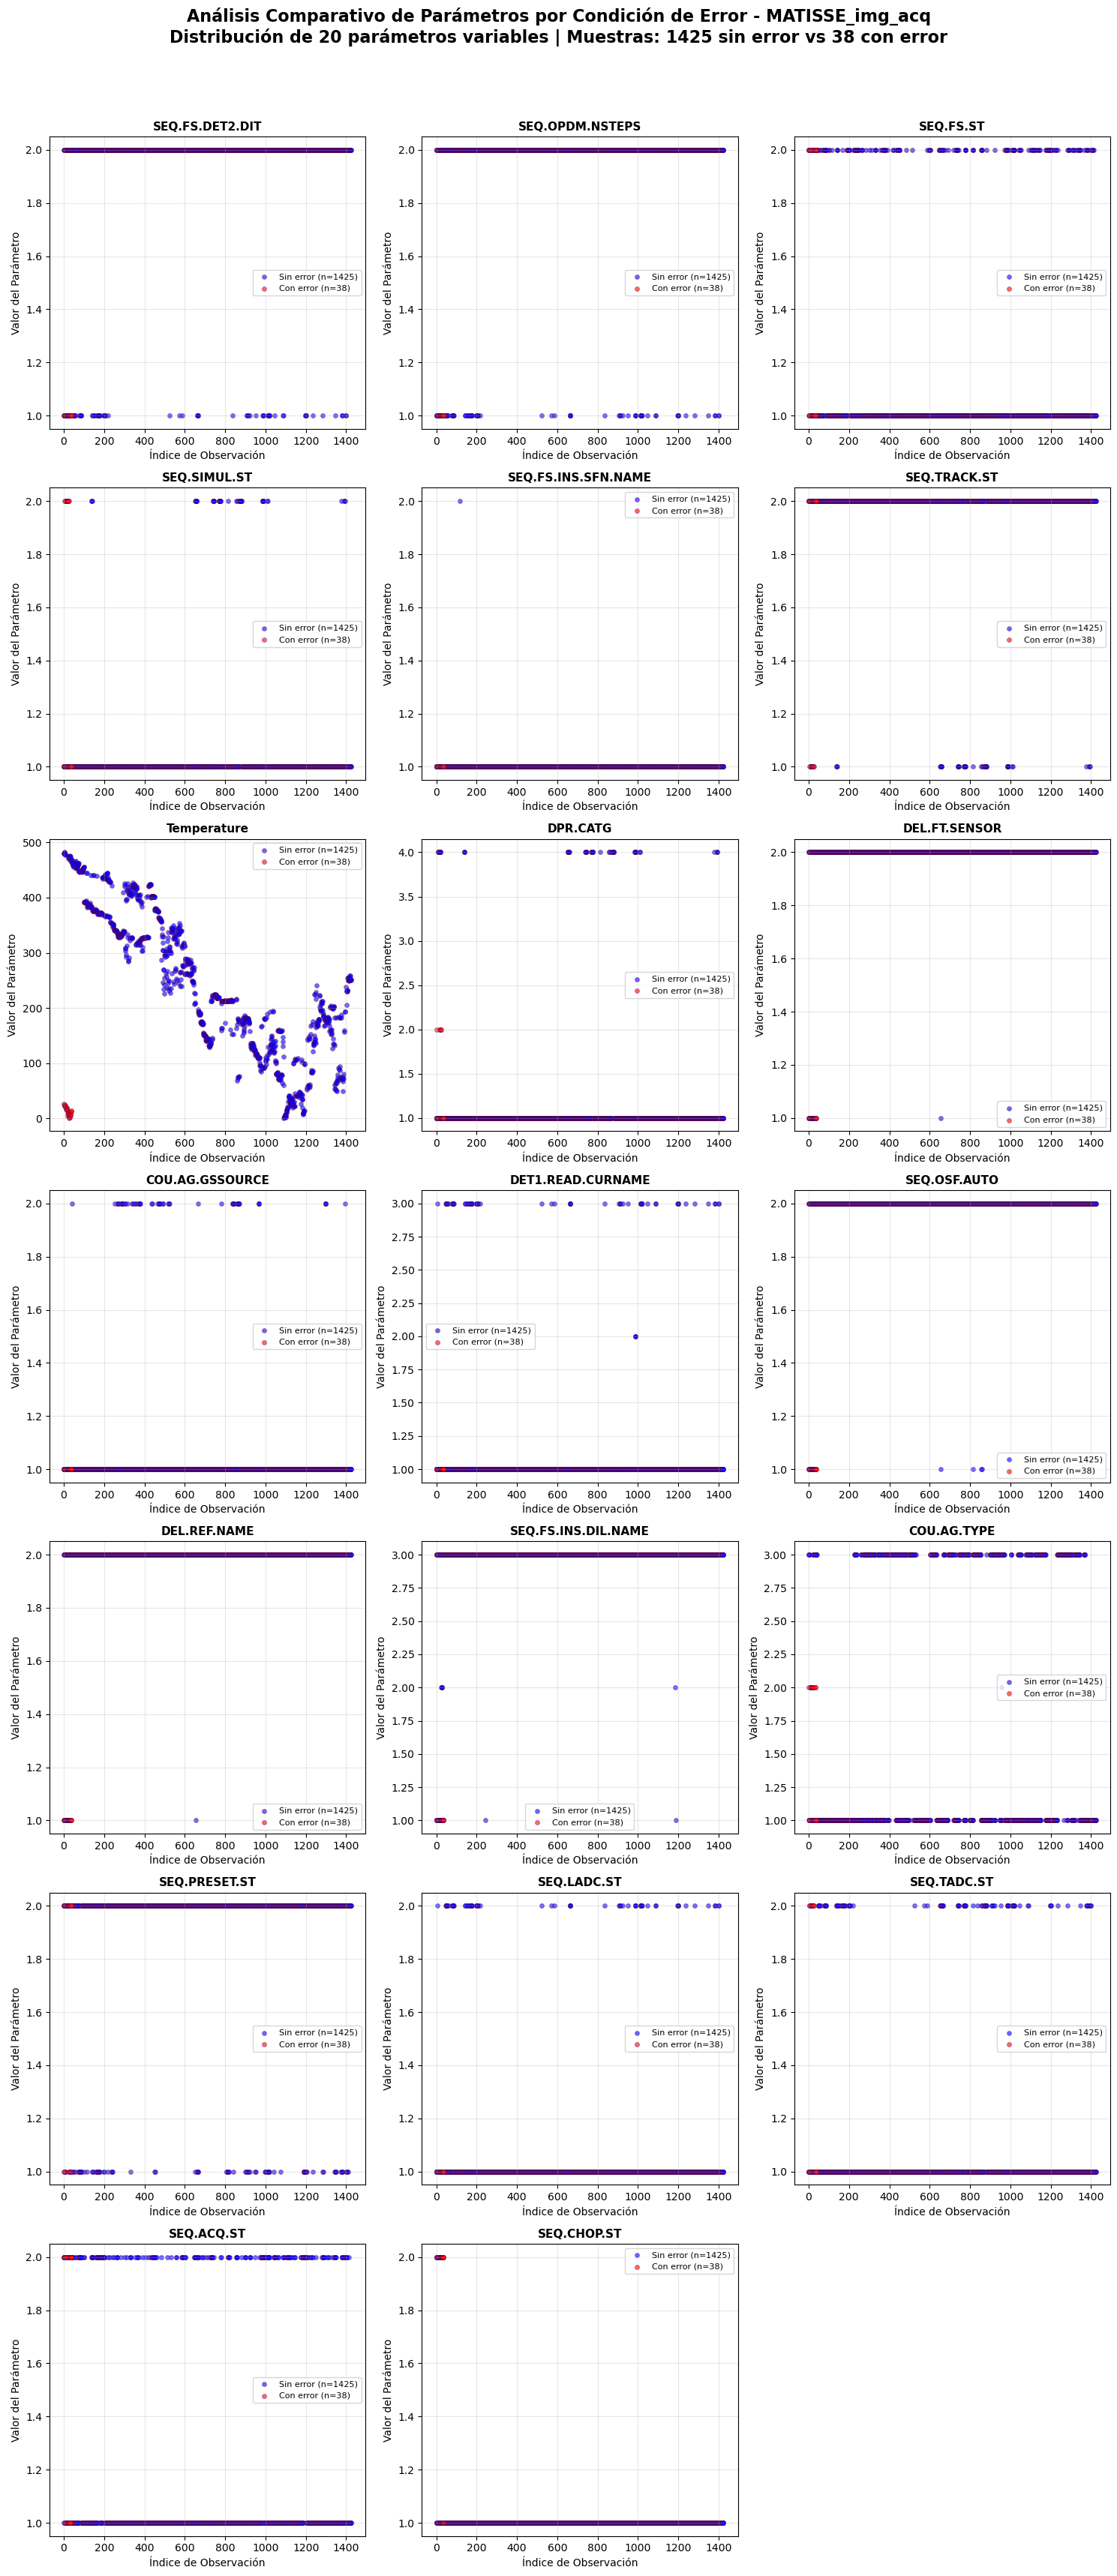

Creando gráficos para 9 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.ACQ.SKY.DURATION', 'SEQ.SKY.OFFS.DELTA', 'DET2.WLMINCUT.VAL', 'SEQ.PUP.DET1.DIT', 'TEL.TARG.PMA', 'DET1.NINCOHERENT.VAL', 'SEQ.ACQ.DET2.DIT', 'DET2.NDIT.SKY', 'SEQ.SIMUL.ST', 'SEQ.OPDM.L.ST', 'INS.STSOFFANG', 'DEL.REF.MODE', 'SEQ.SKY.Y', 'COU.AG.DELTA', 'SEQ.SKY.OFFS.ALPHA', 'DET1.APOY.VAL', 'SEQ.OPDM.N.WLMAX', 'INS.FT.POL', 'SEQ.TARG.FLUX.N', 'TEL.GS1.MAG', 'SEQ.FT.MODE', 'TEL.GS1.ALPHA', 'COU.AG.PMA', 'DEL.FT.SENSOR', 'COU.AG.GSSOURCE', 'COU.AG.EQUINOX', 'SEQ.ACQ.TARG.DURATION', 'SEQ.SKY.X', 'TEL.TARG.ADDVELALPHA', 'COU.GS.MAG', 'DET1.WLMAXCUT.VAL', 'SEQ.ACQ.INS.FIN.NAME', 'DET2.APOY.VAL', 'DEL.REF.NAME', 'SEQ.PUP.SKY.DURATION', 'COU.AG.TYPE', 'COU.AG.PMD', 'DET2.APOTYPE.VAL', 'DET2.INTERFX.VAL', 'DET1.APOTYPE.VAL', 'SEQ.OPDM.N.ST', 'DET1.WLMINCUT.VAL', 'SEQ.TARG.MAG.K', 'INS.SPEC.POL', 'COU.AG.ALPHA', 'DET2.NCOHERENT.VAL', 'DET1.APOX.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.INTERFY.VAL', 'DET2.SNRLIM

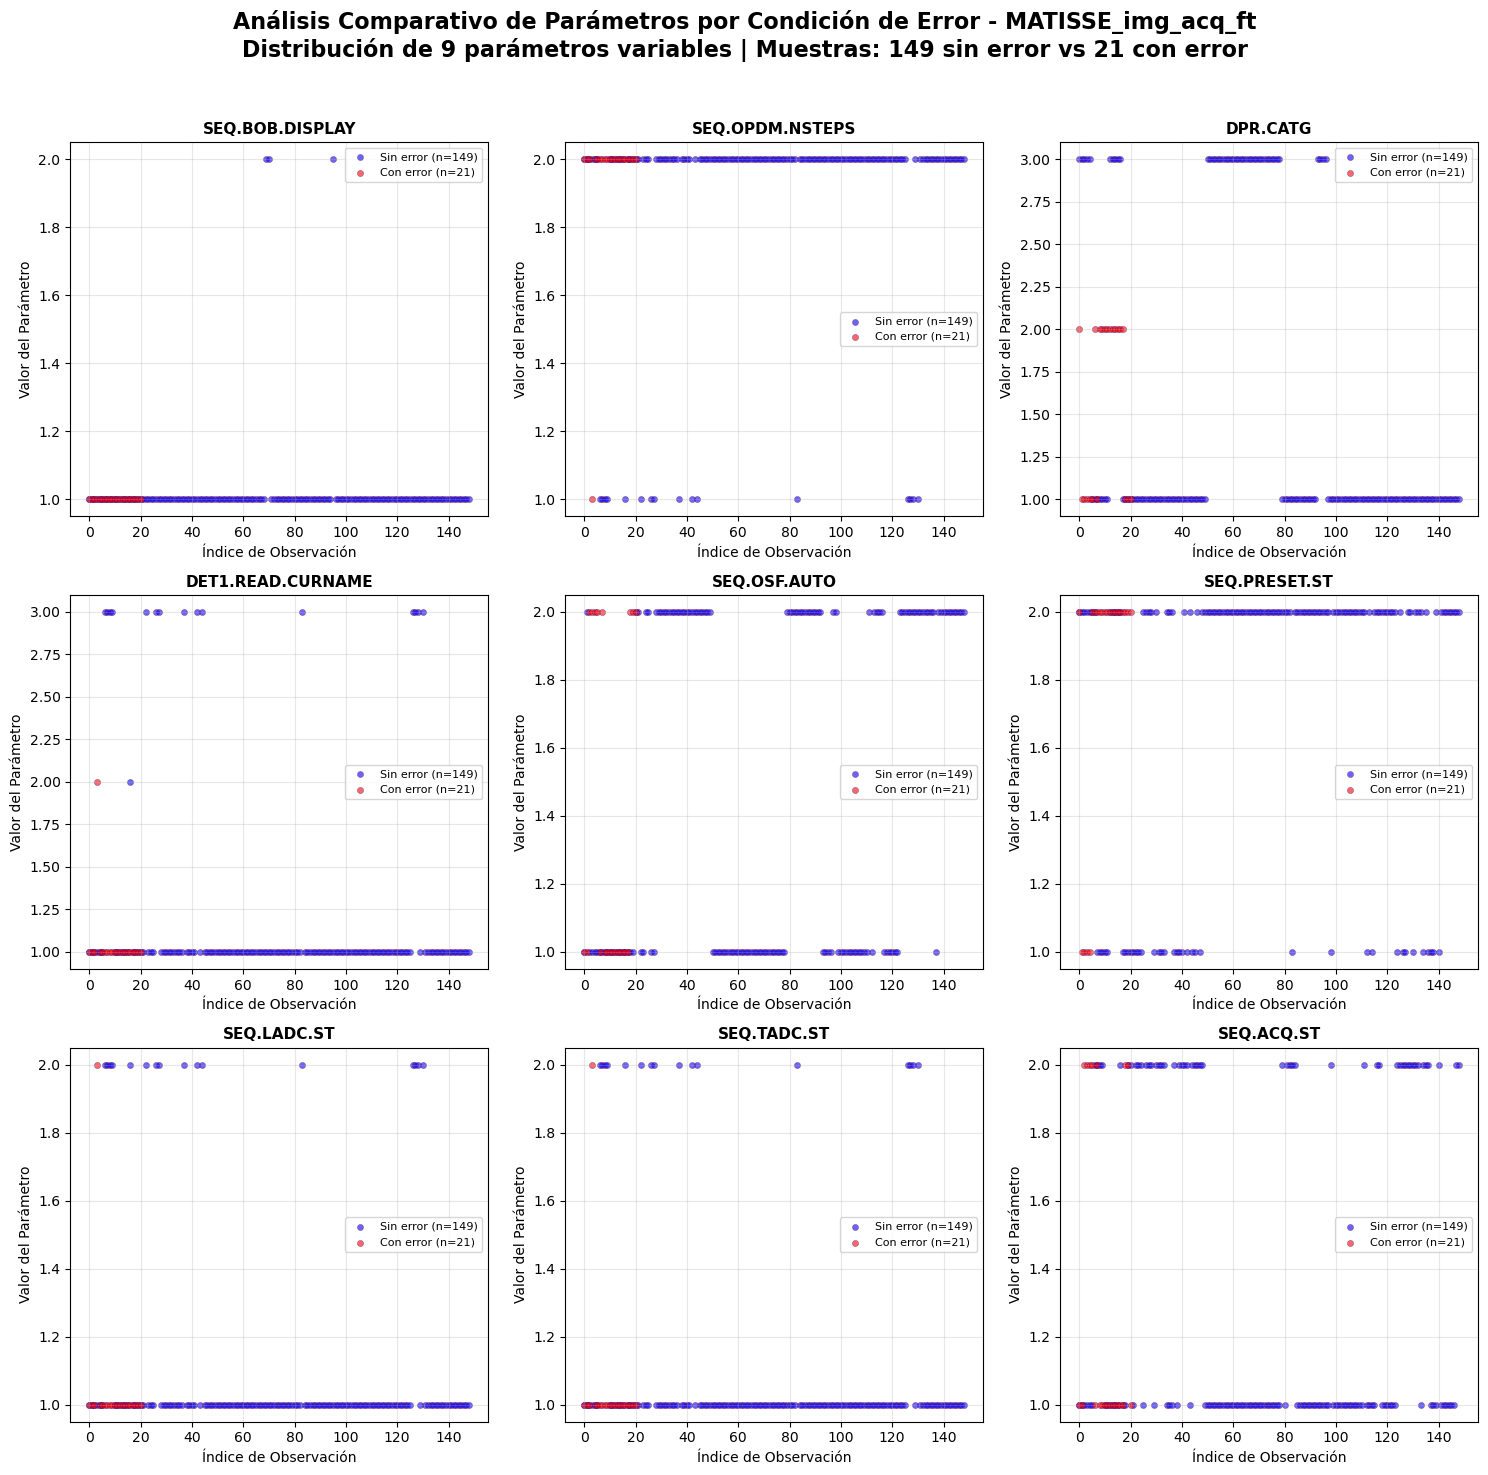

In [17]:
archivos_especificos_tpls = [
    'MATISSE_hyb_obs',
    'MATISSE_img_acq',
    'MATISSE_img_acq_ft'
]

for tpl_id_str in archivos_especificos_tpls:
    df_ok_codified = codified_strval_ok_dfs.get(tpl_id_str)
    df_err_codified = codified_strval_err_dfs.get(tpl_id_str)

    if df_ok_codified is not None and not df_ok_codified.empty and \
       df_err_codified is not None and not df_err_codified.empty:

        threshold = 0.5
        df_ok_cleaned = df_ok_codified.loc[:, df_ok_codified.isna().mean() < threshold]
        df_ok_cleaned = df_ok_cleaned.loc[df_ok_cleaned.isna().mean(axis=1) < threshold, :]

        df_err_cleaned = df_err_codified.loc[:, df_err_codified.isna().mean() < threshold]
        df_err_cleaned = df_err_cleaned.loc[df_err_cleaned.isna().mean(axis=1) < threshold, :]

        if not df_ok_cleaned.empty and not df_err_cleaned.empty:
            columns = list(set(df_ok_cleaned.columns) & set(df_err_cleaned.columns))
            if columns:
                graficos_dispersion_por_columna(df_ok_cleaned[columns], df_err_cleaned[columns],nombre_archivo=tpl_id_str)
            else:
                print(f"No hay columnas comunes después de la limpieza para {tpl_id_str}.")
        else:
            print(f"DataFrame vacío después de la limpieza para {tpl_id_str}. Se omite.")
    else:
        print(f"No se encontraron DataFrames codificados válidos para {tpl_id_str}. Se omite la graficación.")


## 3. Normalización, Reducción de Dimensionalidad (t-SNE/UMAP) y Clustering (DBSCAN)



Se normalizan con Min-Max los datos, reducción de dimensionalidad con t-SNE y UMAP, y clustering DBSCAN **solo a los archivos CSV específicos** (`MATISSE_hyb_obs`, `MATISSE_img_acq` y `MATISSE_img_acq_ft`). 

In [ ]:
output_dir_ok_num = "params_por_tpl"
output_dir_err_num = "params_por_tpl_Error"

specific_tpl_filenames_to_process = [
    'params_MATISSE_hyb_obs.csv',
    'params_MATISSE_img_acq.csv',
    'params_MATISSE_img_acq_ft.csv'
]

resultados_ok_files, resultados_err_files = procesar_archivos_especificos(
    lista_archivos_ok=specific_tpl_filenames_to_process,
    lista_archivos_err=specific_tpl_filenames_to_process,
    carpeta_ok=output_dir_ok_num,
    carpeta_err=output_dir_err_num,
    usar_umap=False
)
print("\nClustering process finished.")
print(f"Results for OK files: {list(resultados_ok_files.keys())}")
print(f"Results for ERROR files: {list(resultados_err_files.keys())}")

DBSCAN Parameters for params_MATISSE_hyb_obs.csv (OK): eps=0.888, min_samples=7
DBSCAN Parameters for params_MATISSE_img_acq.csv (OK): eps=0.626, min_samples=6
DBSCAN Parameters for params_MATISSE_img_acq_ft.csv (OK): eps=0.567, min_samples=5
DBSCAN Parameters for params_MATISSE_hyb_obs.csv (ERROR): eps=0.556, min_samples=5
DBSCAN Parameters for params_MATISSE_img_acq.csv (ERROR): eps=0.441, min_samples=5
DBSCAN Parameters for params_MATISSE_img_acq_ft.csv (ERROR): eps=0.288, min_samples=5

Clustering process finished.
Results for OK files: ['params_MATISSE_hyb_obs.csv', 'params_MATISSE_img_acq.csv', 'params_MATISSE_img_acq_ft.csv']
Results for ERROR files: ['params_MATISSE_hyb_obs.csv', 'params_MATISSE_img_acq.csv', 'params_MATISSE_img_acq_ft.csv']


Graficos combinados para t-sne


Gráfico combinado para: params_MATISSE_hyb_obs.csv

--- Procesando y combinando datos para params_MATISSE_hyb_obs.csv ---
DBSCAN Parameters for Combined Data: eps=0.896, min_samples=7
plot_combined_clusters called with: filename_base=params_MATISSE_hyb_obs.csv, use_umap=False


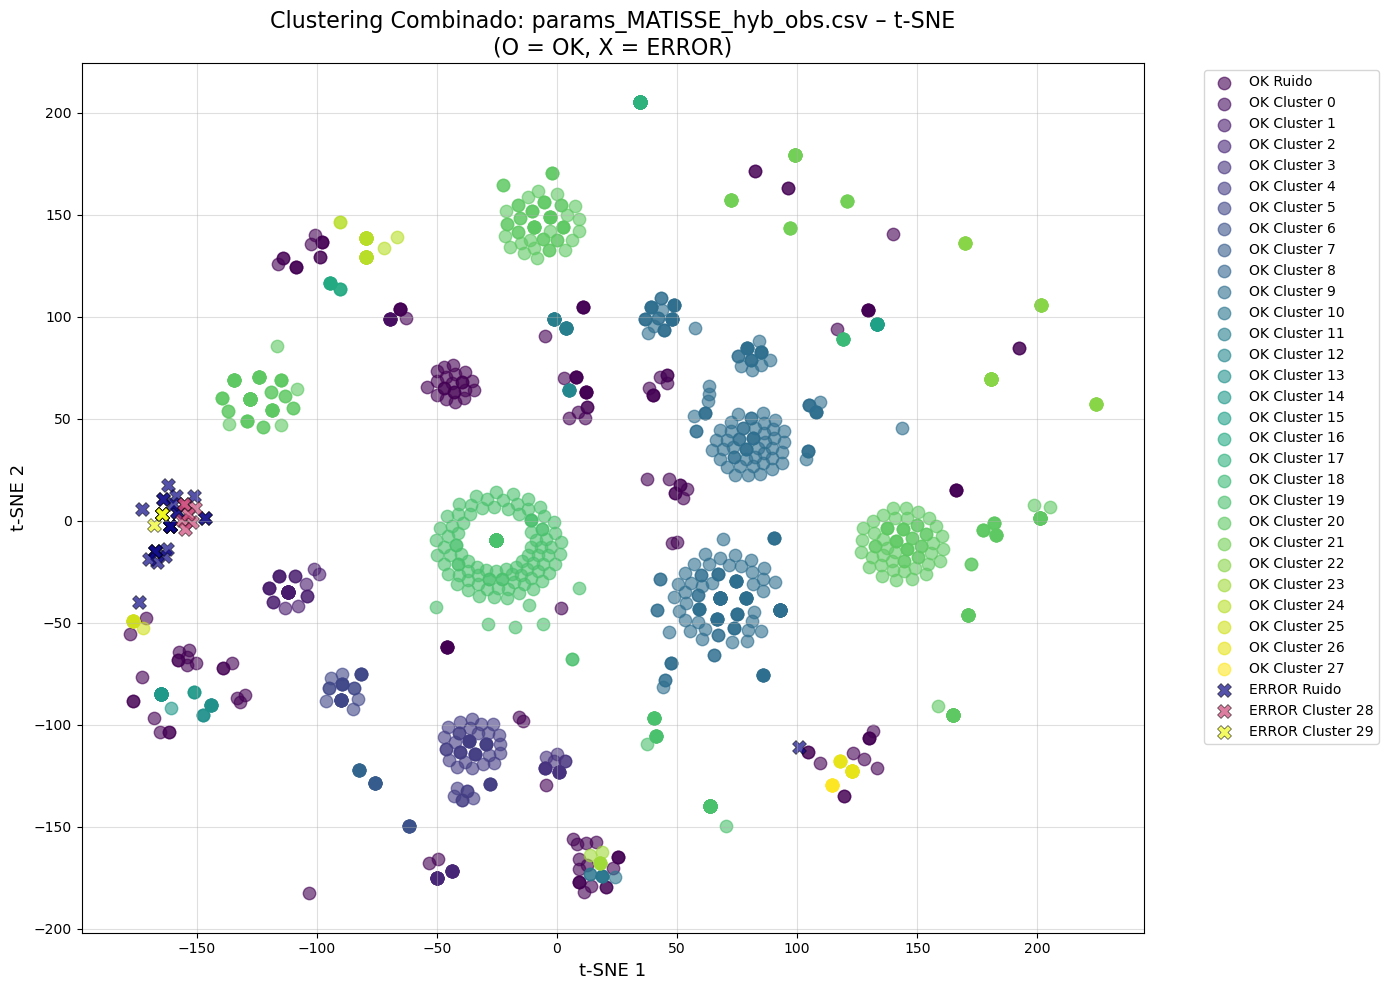


Gráfico combinado para: params_MATISSE_img_acq.csv

--- Procesando y combinando datos para params_MATISSE_img_acq.csv ---
DBSCAN Parameters for Combined Data: eps=0.689, min_samples=7
plot_combined_clusters called with: filename_base=params_MATISSE_img_acq.csv, use_umap=False


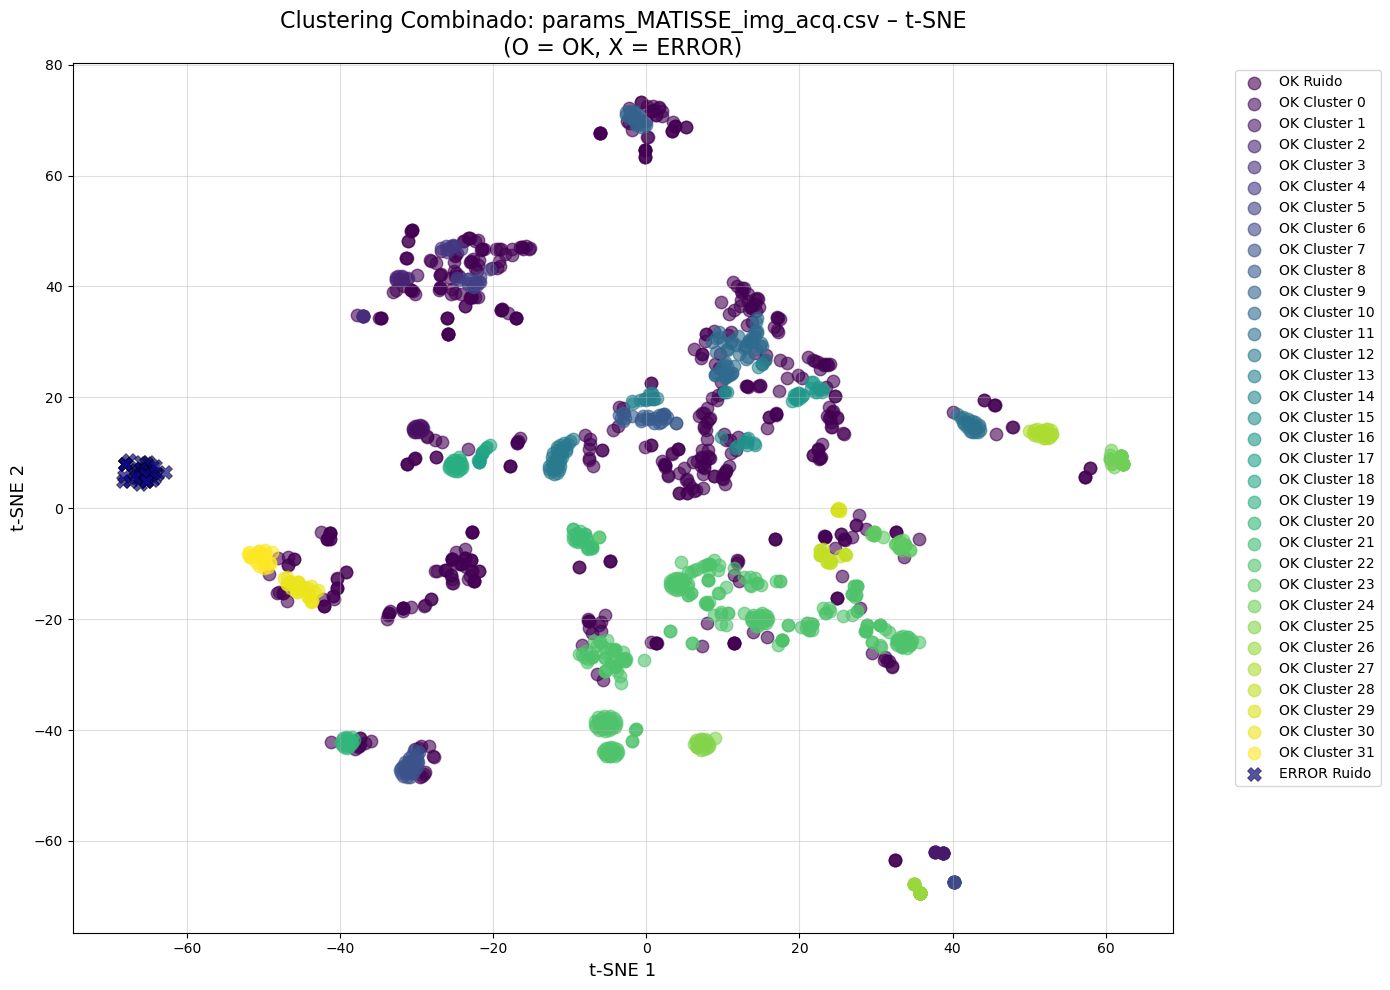


Gráfico combinado para: params_MATISSE_img_acq_ft.csv

--- Procesando y combinando datos para params_MATISSE_img_acq_ft.csv ---
DBSCAN Parameters for Combined Data: eps=0.623, min_samples=5
plot_combined_clusters called with: filename_base=params_MATISSE_img_acq_ft.csv, use_umap=False


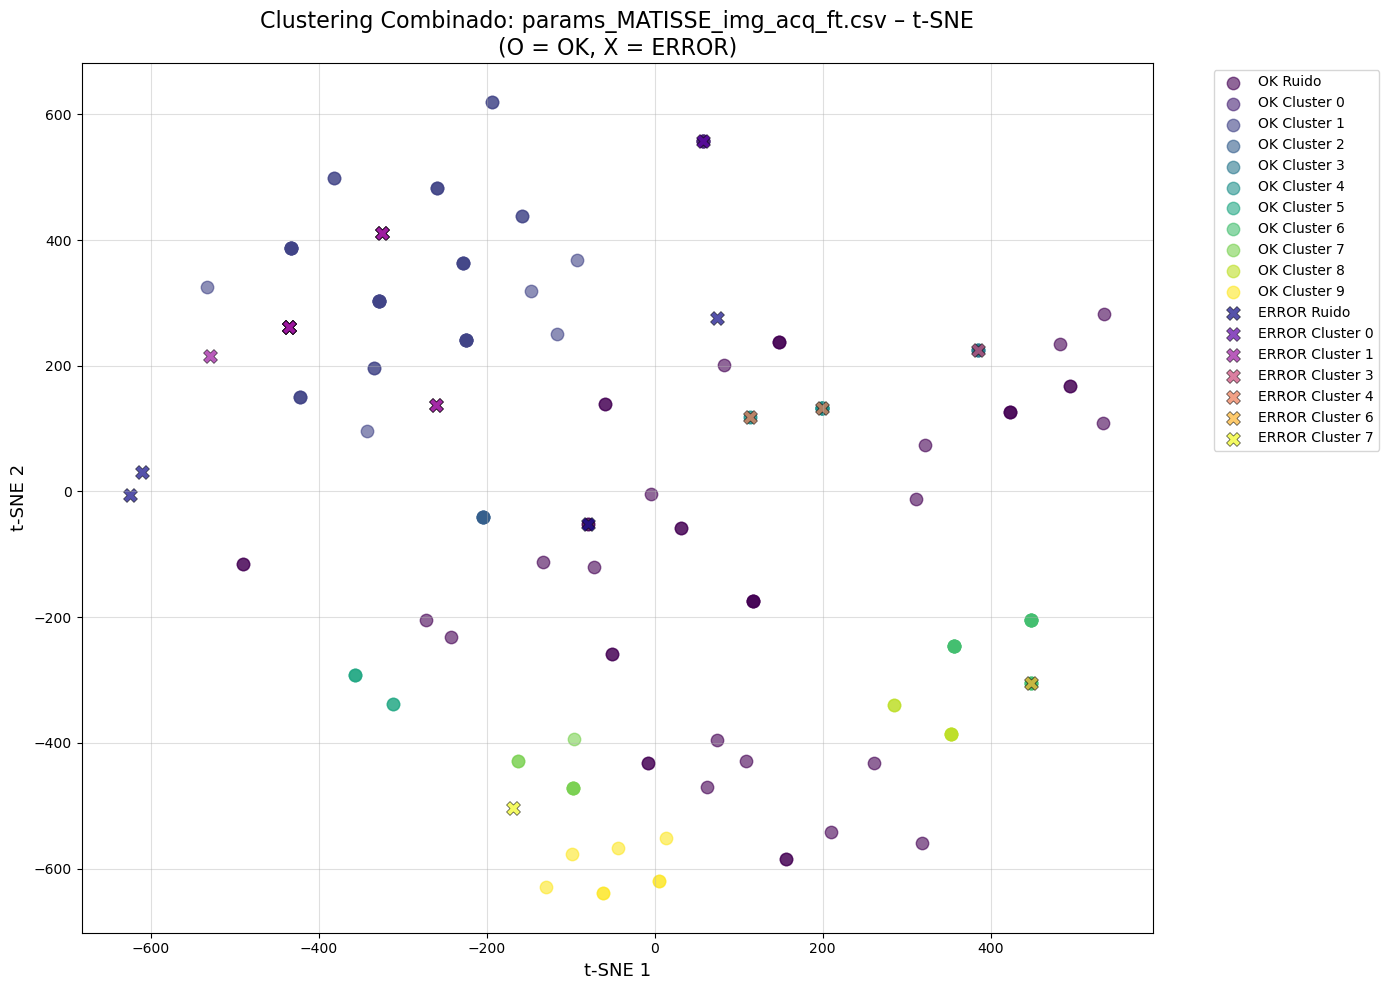

In [5]:
#Graficos combinados
for filename in specific_tpl_filenames_to_process:
    print(f"\nGráfico combinado para: {filename}")
    
    df_ok_path = os.path.join(output_dir_ok_num, filename)
    df_err_path = os.path.join(output_dir_err_num, filename)
    
    if os.path.exists(df_ok_path) and os.path.exists(df_err_path):
        cluster_and_plot_combined(
            df_ok_path=df_ok_path,
            df_err_path=df_err_path,
            filename_base=filename,
            use_umap=False,  
            dbscan_eps=None, 
            dbscan_min_samples=None
        )
    else:
        print(f"  - Advertencia: No se encontraron ambos archivos para {filename}")
        if not os.path.exists(df_ok_path):
            print(f"    Missing OK file: {df_ok_path}")
        if not os.path.exists(df_err_path):
            print(f"    Missing ERROR file: {df_err_path}")


In [ ]:
output_dir_ok_num = "params_por_tpl"
output_dir_err_num = "params_por_tpl_Error"

specific_tpl_filenames_to_process = [
    'params_MATISSE_hyb_obs.csv',
    'params_MATISSE_img_acq.csv',
    'params_MATISSE_img_acq_ft.csv'
]

resultados_ok_files, resultados_err_files = procesar_archivos_especificos(
    lista_archivos_ok=specific_tpl_filenames_to_process,
    lista_archivos_err=specific_tpl_filenames_to_process,
    carpeta_ok=output_dir_ok_num,
    carpeta_err=output_dir_err_num,
    usar_umap=True
)
print("\nClustering process finished.")
print(f"Results for OK files: {list(resultados_ok_files.keys())}")
print(f"Results for ERROR files: {list(resultados_err_files.keys())}")

DBSCAN Parameters for params_MATISSE_hyb_obs.csv (OK): eps=0.888, min_samples=7


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN Parameters for params_MATISSE_img_acq.csv (OK): eps=0.626, min_samples=6


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN Parameters for params_MATISSE_img_acq_ft.csv (OK): eps=0.567, min_samples=5


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN Parameters for params_MATISSE_hyb_obs.csv (ERROR): eps=0.556, min_samples=5
DBSCAN Parameters for params_MATISSE_img_acq.csv (ERROR): eps=0.441, min_samples=5
DBSCAN Parameters for params_MATISSE_img_acq_ft.csv (ERROR): eps=0.288, min_samples=5

Clustering process finished.
Results for OK files: ['params_MATISSE_hyb_obs.csv', 'params_MATISSE_img_acq.csv', 'params_MATISSE_img_acq_ft.csv']
Results for ERROR files: ['params_MATISSE_hyb_obs.csv', 'params_MATISSE_img_acq.csv', 'params_MATISSE_img_acq_ft.csv']


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Graficos combiandos para UMAP


Gráfico combinado para: params_MATISSE_hyb_obs.csv

--- Procesando y combinando datos para params_MATISSE_hyb_obs.csv ---
DBSCAN Parameters for Combined Data: eps=0.896, min_samples=7


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


plot_combined_clusters called with: filename_base=params_MATISSE_hyb_obs.csv, use_umap=True


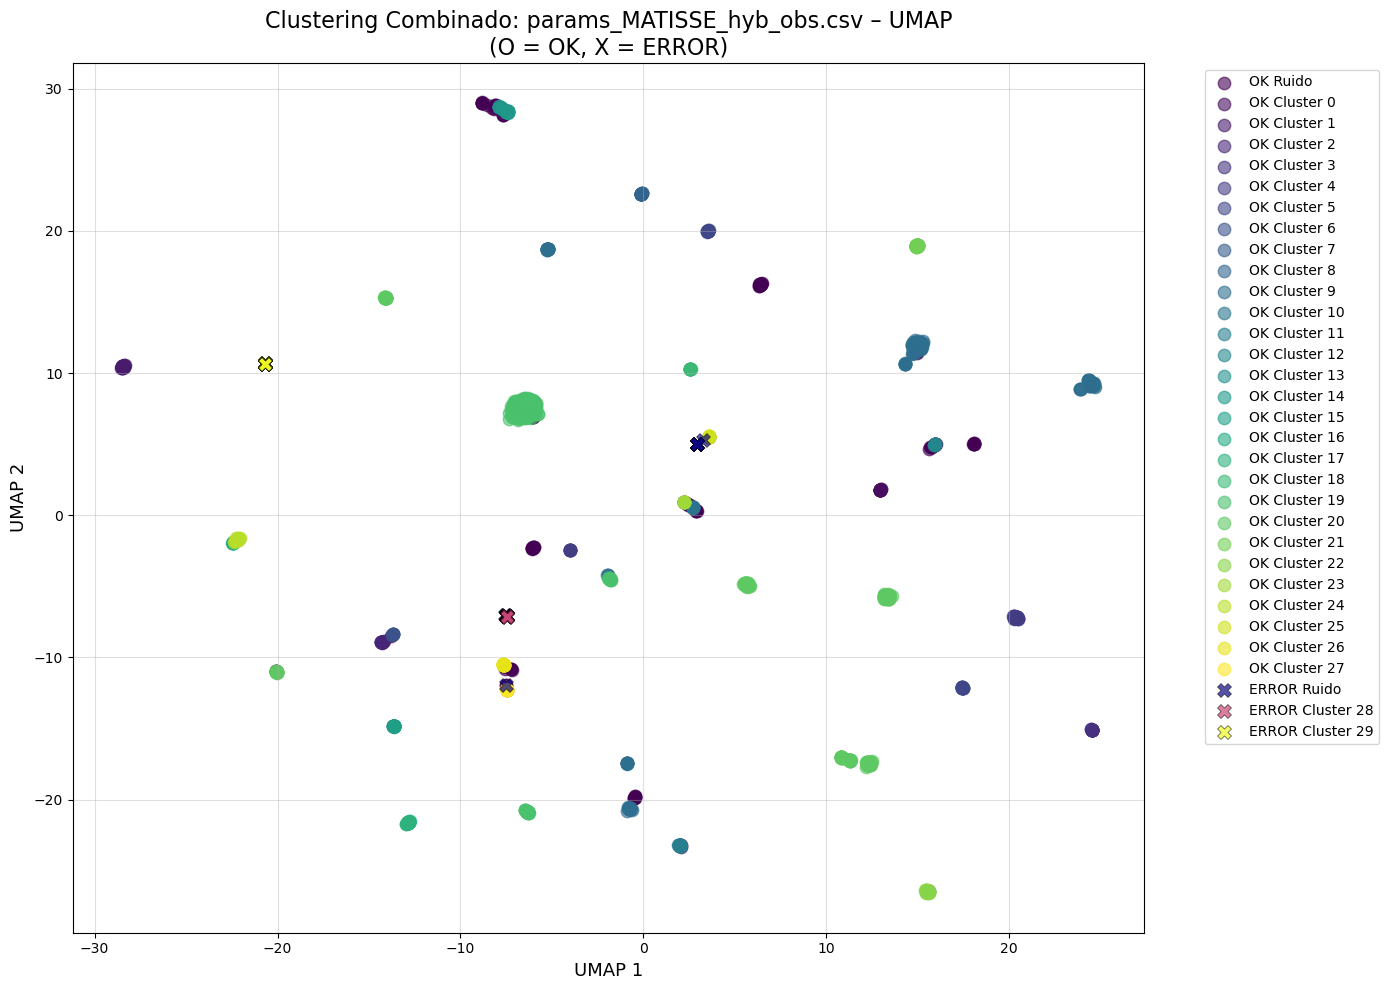


Gráfico combinado para: params_MATISSE_img_acq.csv

--- Procesando y combinando datos para params_MATISSE_img_acq.csv ---
DBSCAN Parameters for Combined Data: eps=0.689, min_samples=7


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


plot_combined_clusters called with: filename_base=params_MATISSE_img_acq.csv, use_umap=True


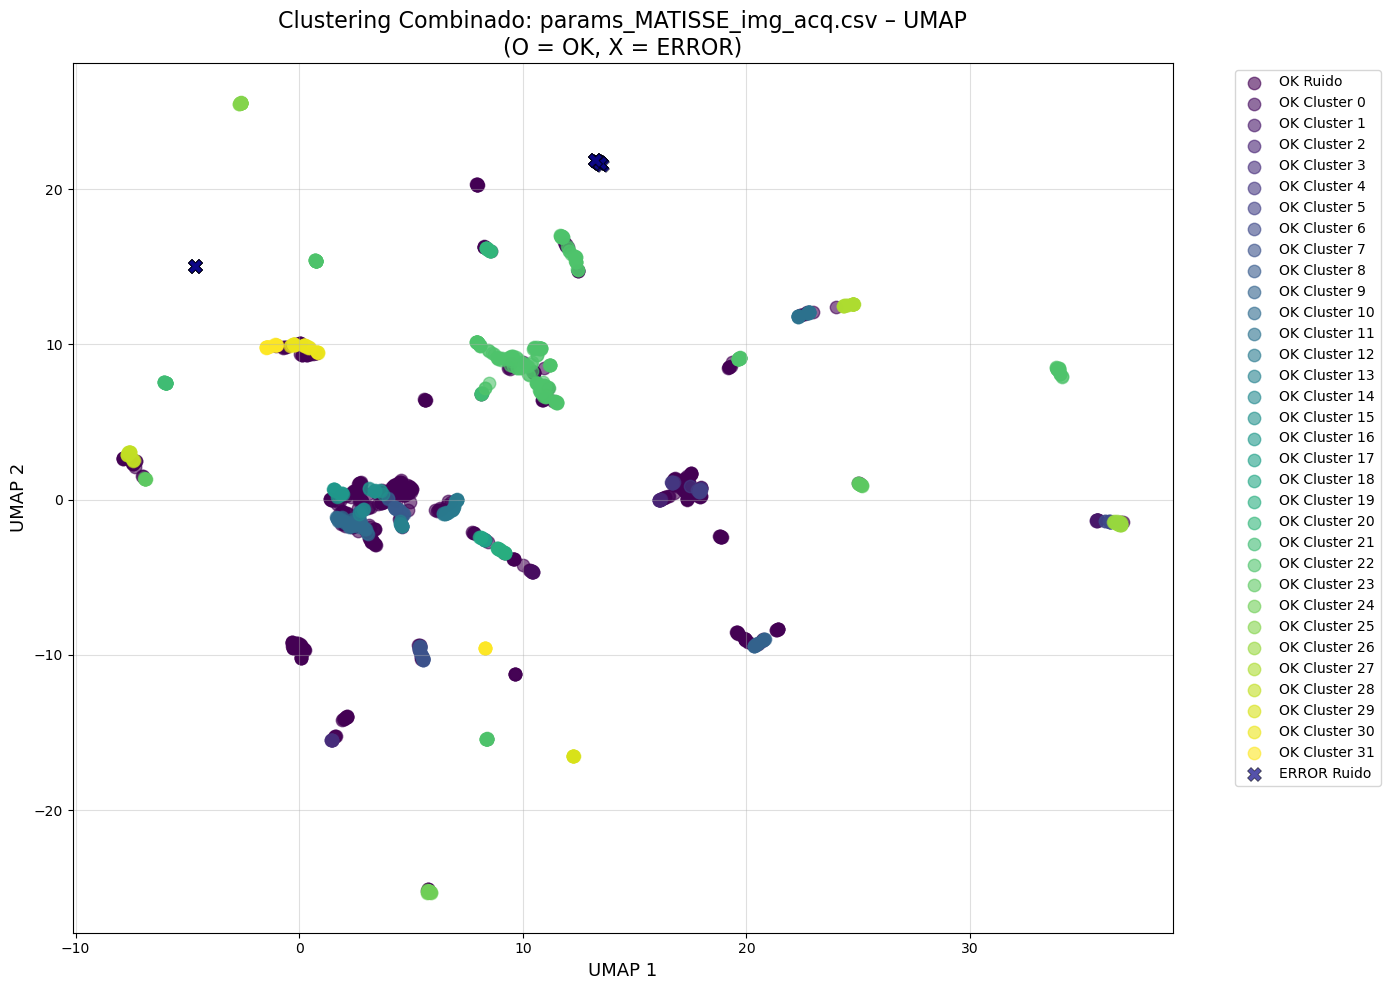


Gráfico combinado para: params_MATISSE_img_acq_ft.csv

--- Procesando y combinando datos para params_MATISSE_img_acq_ft.csv ---
DBSCAN Parameters for Combined Data: eps=0.623, min_samples=5


c:\Users\vosse\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


plot_combined_clusters called with: filename_base=params_MATISSE_img_acq_ft.csv, use_umap=True


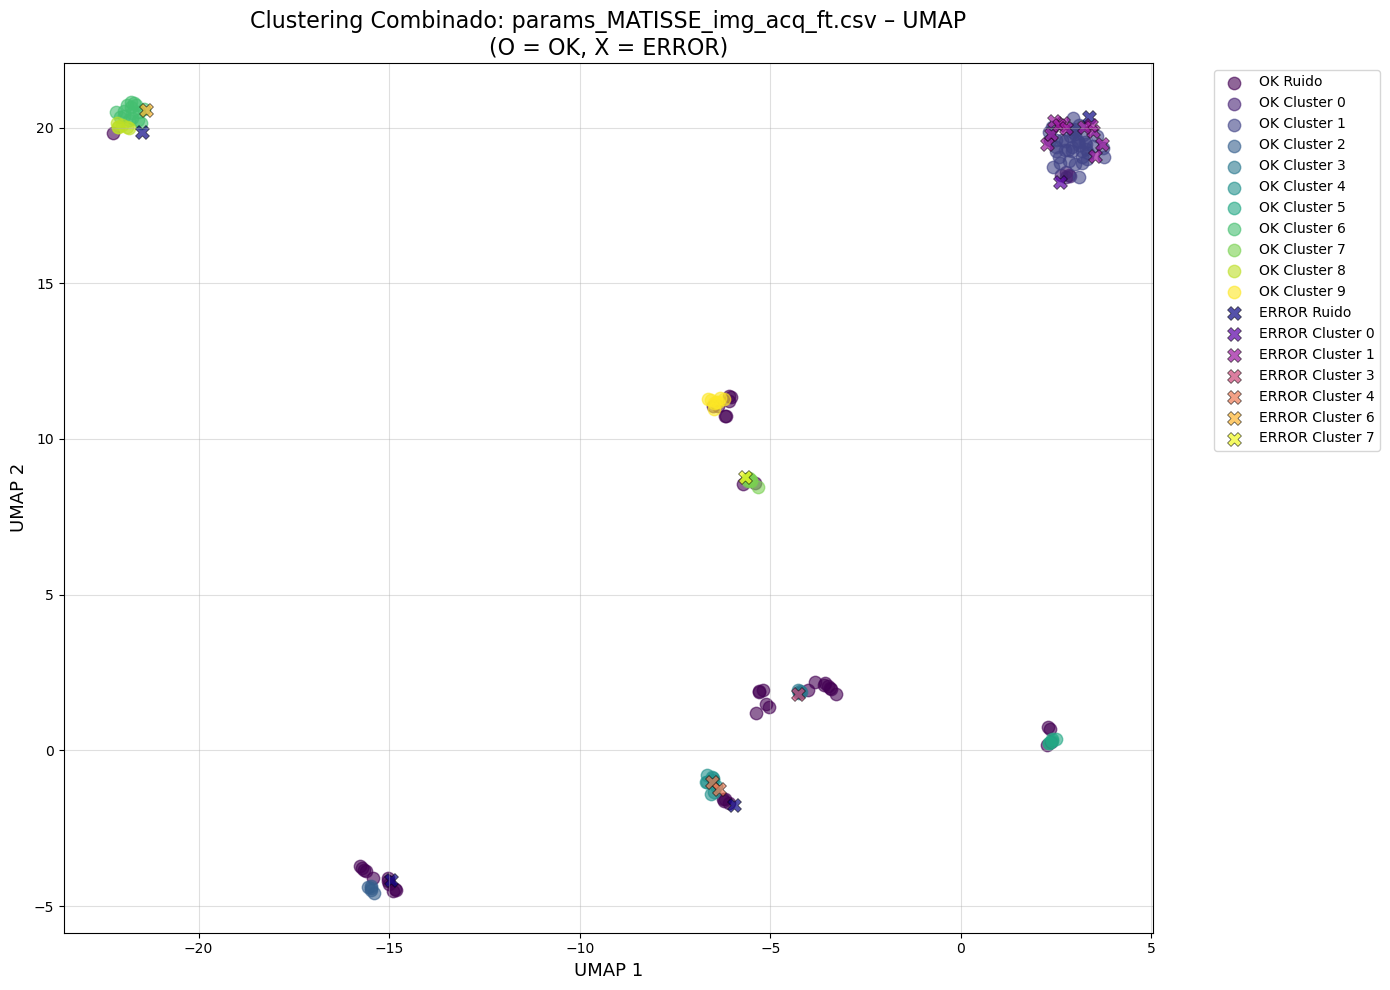

In [7]:
#Graficos combinados
for filename in specific_tpl_filenames_to_process:
    print(f"\nGráfico combinado para: {filename}")
    
    df_ok_path = os.path.join(output_dir_ok_num, filename)
    df_err_path = os.path.join(output_dir_err_num, filename)
    
    if os.path.exists(df_ok_path) and os.path.exists(df_err_path):
        cluster_and_plot_combined(
            df_ok_path=df_ok_path,
            df_err_path=df_err_path,
            filename_base=filename,
            use_umap=True,  
            dbscan_eps=None, 
            dbscan_min_samples=None
        )
    else:
        print(f"  - Advertencia: No se encontraron ambos archivos para {filename}")
        if not os.path.exists(df_ok_path):
            print(f"    Missing OK file: {df_ok_path}")
        if not os.path.exists(df_err_path):
            print(f"    Missing ERROR file: {df_err_path}")